# Signed Graph Network Analysis

## Setup

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
from matplotlib_venn import venn2
from sklearn.ensemble import IsolationForest

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import smogn

#regression models
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
from gensim.models import Word2Vec


## Analysis

### A) Graph Import, Adjacency Matrix

In [3]:
# Import the weighted graph using the specified nodes in the first and second columns. The weight is specified in the third column. 
# Generate an adjacency matrix and save it to an Excel file.

In [4]:
graph_df = pd.read_csv("data/soc-sign-bitcoinalpha.csv", header=None)
graph_df.columns = ["source", "target", "weight", "time"]
G = nx.from_pandas_edgelist(graph_df, source="source", target="target", edge_attr="weight", create_using=nx.DiGraph)
graph_df

source  target  weight        time
0        7188       1      10  1407470400
1         430       1      10  1376539200
2        3134       1      10  1369713600
3        3026       1      10  1350014400
4        3010       1      10  1347854400
...       ...     ...     ...         ...
24181    7604    7601      10  1364270400
24182    7601    7604      10  1364270400
24183    7604    7602      10  1364270400
24184    7602    7604      10  1364270400
24185    7604    7603     -10  1364270400

[24186 rows x 4 columns]

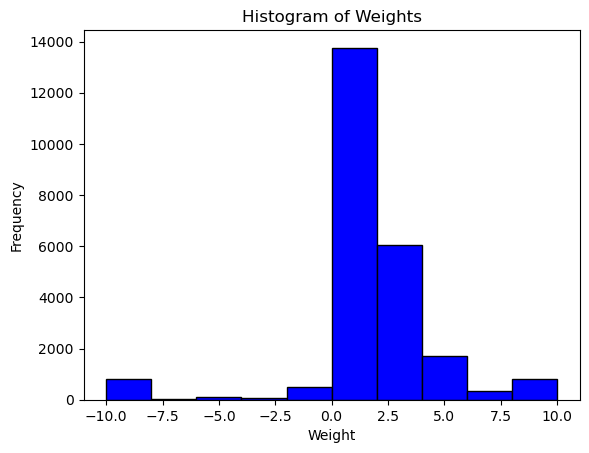

In [5]:
#histogram of weights 
plt.hist(graph_df["weight"], bins=10, color="blue", edgecolor="black")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.savefig("plots/histogram_of_weights.pdf")
plt.title("Histogram of Weights")
plt.show()


In [6]:
graph_df["weight"].groupby(graph_df["weight"]).count().sort_values(ascending=False)

weight
 1     13760
 2      4113
 3      1933
 5       957
-10      812
 4       744
 10      494
-1       429
 8       224
 6       201
 7       149
-5       112
 9        75
-2        68
-3        62
-8        15
-4        14
-9        13
-6         6
-7         5
Name: weight, dtype: int64

In [7]:
adjacency_matrix = nx.adjacency_matrix(G).todense()
print("Shape of the adjacency matrix: ", adjacency_matrix.shape)

#save to excel file
adjacency_df = pd.DataFrame(adjacency_matrix)

#adjacency_df.to_excel("data/adjacency_matrix.csv", index=False) -> incredibly slow, therefore chose to save as csv
adjacency_df.to_excel("data/adjacency_matrix.xlsx", index=False)

C:\Users\minda\AppData\Local\Temp\ipykernel_39632\3338292792.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G).todense()


Shape of the adjacency matrix:  (3783, 3783)


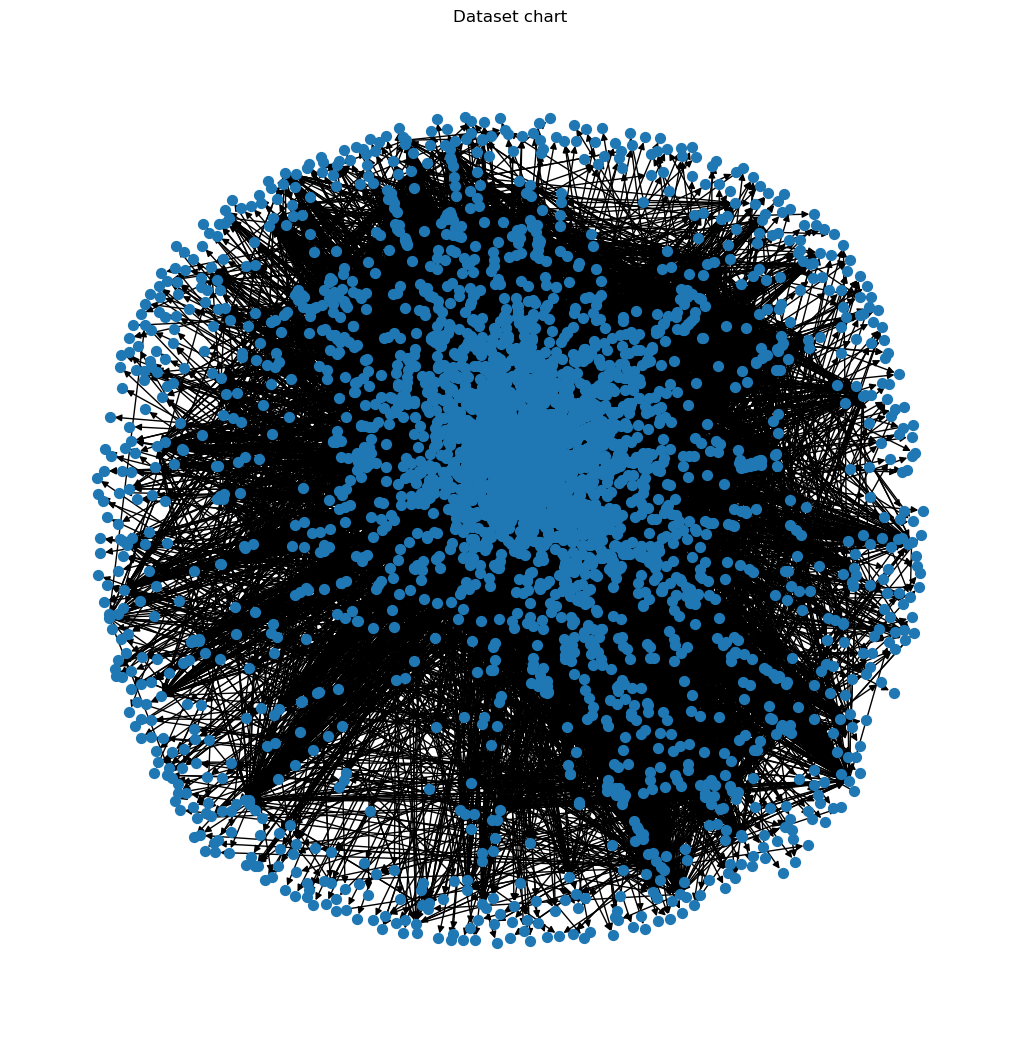

In [8]:
plt.figure(figsize=(10, 10))
nx.draw(G, node_size = 50)
filename = "plots/Dataset_chart.pdf"
plt.savefig(filename)
plt.title(f"Dataset chart")
plt.show()

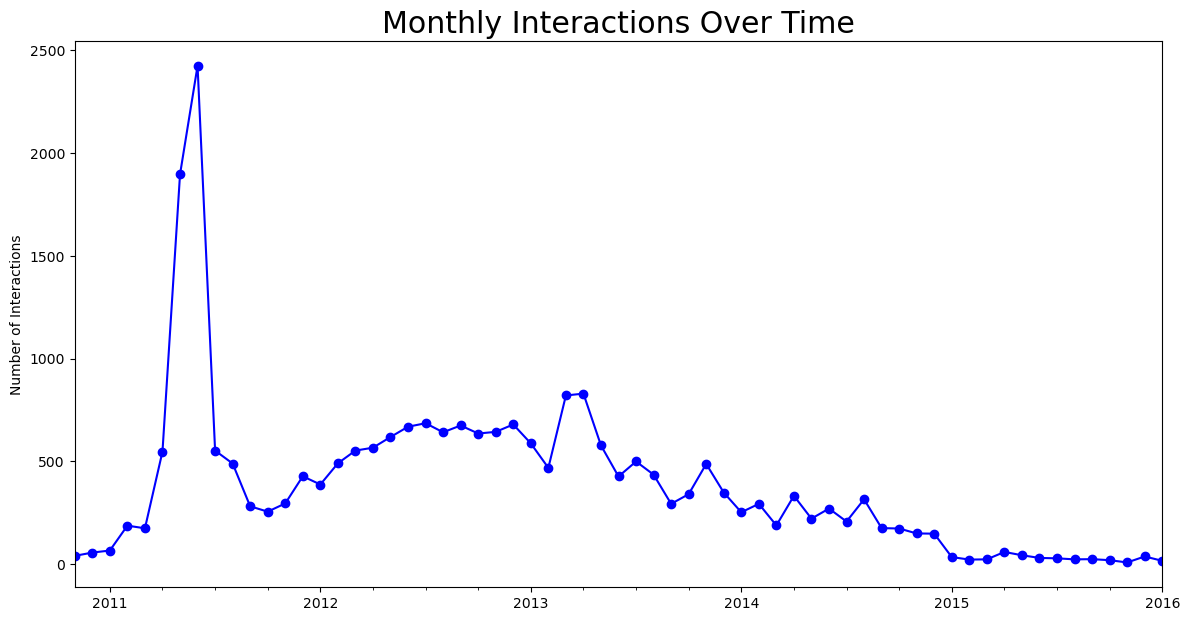

In [9]:
# If the time column is not already in datetime format, convert it
graph_df["time"] = pd.to_datetime(graph_df["time"], unit='s')  # Use 's' if time is in seconds, adjust as necessary

# Resampling to see how activity changes over time (monthly example)
monthly_activity = graph_df.resample('M', on='time').size()  # 'M' stands for monthly; other options: 'D' for daily, 'W' for weekly, etc.

plt.figure(figsize=(12, 6))
monthly_activity.plot(kind='line', marker='o', linestyle='-', color='b')

plt.ylabel("Number of Interactions")
plt.xlabel("")
plt.tight_layout()
plt.rcParams.update({'font.size': 18})
filename = "plots/time_distribution.pdf"
plt.savefig(filename)
plt.title("Monthly Interactions Over Time")
plt.show()
import matplotlib as mpl

# Get the default font size
default_font_size = mpl.rcParamsDefault['font.size']

# Reset the font size to its default value
plt.rcParams.update({'font.size': default_font_size})

### B) Degree Distribtion, Power Law, 

In [5]:
# Using NetworkX, plot the in/out-degree distribution
# and fit the power-law distribution. Use curve fitting and
# confidence bounds of the curve fit library and evaluate
# if the power law distribution can be fit with 80%
# confidence. Additionally, calculate the average clustering
# coefficient and diameter.

In [10]:
def calculate_degrees(degree_dict):
    degree_sequence = sorted([d for n, d in degree_dict], reverse=True)
    degree_count = {}
    for degree in degree_sequence:
        if degree in degree_count:
            degree_count[degree] += 1
        else:
            degree_count[degree] = 1
    return zip(*degree_count.items())


def plot_degree(degree, count, title, save_path):
    plt.bar(degree, count, color='b', label = "NumberOfNodes")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.xlim(0, 100)
    plt.ylim(0, max(count))
    plt.legend()
    plt.savefig(f"plots/{save_path}.pdf")
    #keep title out of saved version
    plt.title(title)
    plt.show()

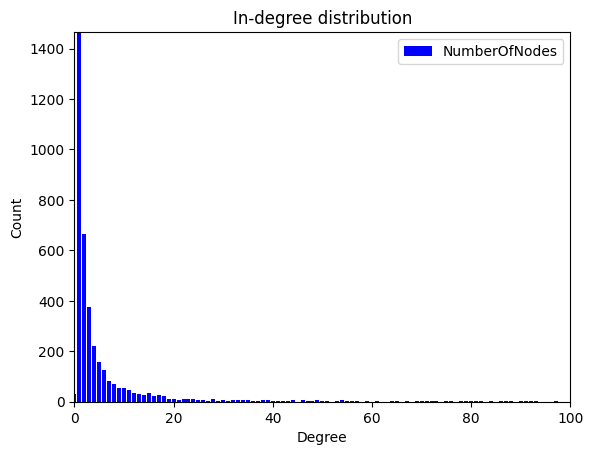

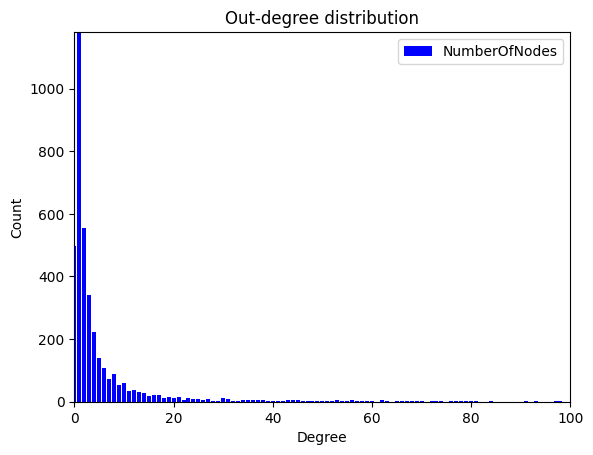

In [82]:
in_degree, in_count = calculate_degrees(G.in_degree())
plot_degree(in_degree, in_count, "In-degree distribution", "B_in_degree_distribution")
out_degree, out_count = calculate_degrees(G.out_degree())
plot_degree(out_degree, out_count, "Out-degree distribution", "B_out_degree_distribution")

In [88]:
# percentage of nodes with in / out degress under 20
in_degree_under_10= sum(in_count[-10:]) / sum(in_count)
out_degree_under_10 = sum(out_count[-10:]) / sum(out_count)

print(f"Percentage of nodes with in-degree under 10: {in_degree_under_10}")
print(f"Percentage of nodes with out-degree under 10: {out_degree_under_10}")

Percentage of nodes with in-degree under 20: 0.8569918054454136
Percentage of nodes with out-degree under 20: 0.8604282315622522


In [11]:
def linlaw(x, a, b) :
    return np.log(a) + x * b

def fit_and_plot_powerlaw(degree, count, title, save_path):
    degree, count = np.log(degree)[:-1], np.log(count)[:-1]
    popt_log, pcov_log = curve_fit(linlaw, degree, count)

    hires_x = np.linspace(0, max(degree), 100)
    # Calculate standard errors of the parameters
    sigma_ab = np.sqrt(np.diagonal(pcov_log))

    # Calculate critical value for an 80% confidence interval
    z = norm.ppf(0.9)  # for an 80% confidence interval

    # Calculate confidence bounds
    bound_upper = linlaw(hires_x, *(popt_log + z * sigma_ab))
    bound_lower = linlaw(hires_x, *(popt_log - z * sigma_ab))

    print(f"Optimal parameters: a={popt_log[0]}, b={popt_log[1]}")
    plt.scatter(degree, count, color='b')
    plt.plot(degree, linlaw(degree, *popt_log), 'r--', label = "Fitted Curve")
    plt.fill_between(hires_x, bound_lower, bound_upper, color='black', alpha=0.15, label='80% Confidence Interval')  # plotting the confidence intervals
    plt.xlabel("log(Degree)")
    plt.ylabel("log(Count)")
    plt.legend(loc='best')
    plt.savefig(f"plots/{save_path}.pdf")
    plt.title(title)
    plt.show()

/tmp/ipykernel_39530/2130378041.py:5: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


Optimal parameters: a=1050.1333867565952, b=-1.4768509049523104


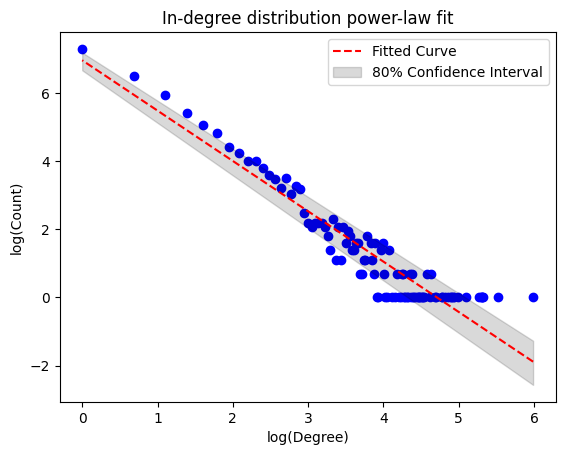

/tmp/ipykernel_39530/2130378041.py:5: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


Optimal parameters: a=745.6386171455763, b=-1.3892366867563806


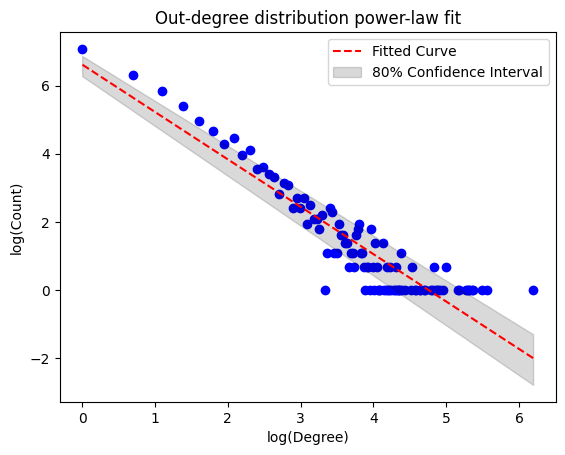

In [85]:
fit_and_plot_powerlaw(in_degree, in_count, "In-degree distribution power-law fit", "B_in_degree_distribution_powerlaw_fit")
fit_and_plot_powerlaw(out_degree, out_count, "Out-degree distribution power-law fit", "B_out_degree_distribution_powerlaw_fit")

In [67]:
#Additionally, calculate the average clustering coefficient and diameter.
average_clustering_coefficient = nx.average_clustering(G)
print("Average clustering coefficient: ", average_clustering_coefficient)

#identify biggest strongly connected component first
strongly_connected_components = nx.strongly_connected_components(G)
biggest_strongly_connected_component = max(strongly_connected_components, key=len)
G_strongly_connected = G.subgraph(biggest_strongly_connected_component)
diameter = nx.diameter(G_strongly_connected)
print("Diameter: ", diameter)


Average clustering coefficient:  0.15834486458303135
Diameter:  10


In [75]:
print(f"dropped nodes: {len(G.nodes) - len(biggest_strongly_connected_component)}")
print(f"dropped edges: {len(G.edges)-len(G_strongly_connected.edges)}")
print(f"nodes: {len(G.nodes)}")
print(f"edges: {len(G.edges)}")

dropped nodes: 548
dropped edges: 887
nodes: 3783
edges: 24186


In [68]:
#do same but treat graph as undirected
connected_components = nx.connected_components(G.to_undirected())
biggest_connected_component = max(connected_components, key=len)
G_connected = G.to_undirected().subgraph(biggest_connected_component)
diameter = nx.diameter(G_connected)
print("Diameter (undirected): ", diameter)

Diameter (undirected):  10


In [80]:
print(f"dropped nodes: {len(G.nodes) - len(biggest_connected_component)}")
print(f"dropped edges: {len(G.to_undirected().edges)-len(G_connected.edges)}")
print(f"nodes: {len(G.nodes)}")
print(f"edges: {len(G.to_undirected().edges)}")

dropped nodes: 8
dropped edges: 4
nodes: 3783
edges: 14124


### C) K-plex Communities

In [12]:
#Identify the communities of the network using the k-plex algorithm as implemented in
#NetworkX. 
#Use appropriate visualization tools to display a dense representation of these
#communities.

In [13]:
def analyze_k_plexes(G, name):

    # Largest strongly connected component
    def largest_strongly_connected_component(graph):
        components = list(nx.strongly_connected_components(graph))
        largest_component = max(components, key=len)
        return graph.subgraph(largest_component)

    # Calculate k-value based on the minimum degree
    def calculate_k(subgraph):
        min_degree = min(dict(subgraph.degree()).values())
        k = max(1, min(len(subgraph) - min_degree, len(subgraph) // 2))
        return k

    # Find k-plexes in the directed graph
    def find_k_plex(graph, k):
        components = list(nx.strongly_connected_components(graph))
        k_plexes = []

        for component in components:
            subgraph = graph.subgraph(component)
            if all(degree >= (len(subgraph) - k) for _, degree in subgraph.degree()):
                k_plexes.append(subgraph)

        return k_plexes

    # Plot k-plexes
    def plot_k_plexes(graph, k_plexes):
        pos = nx.spring_layout(graph)  # Layout
        plt.figure(figsize=(10, 10))

        colors = plt.cm.rainbow(np.linspace(0, 1, len(k_plexes)))
        for color, k_plex in zip(colors, k_plexes):
            nx.draw(k_plex, pos, node_color=color, edge_color='black', alpha=0.8, node_size=200)

        plt.title(f"K-Plex nodes")
        filename = "plots/" + name + "_k_plex_communities.pdf"
        plt.savefig(filename)
        plt.show()

    # Plot k-plexes with node size variation based on the total nodes in each k-plex
    def plot_k_plexes_nodes(graph, k_plexes):
        pos = nx.spring_layout(graph)  # Layout
        plt.figure(figsize=(10, 10))

        # Define colors for k-plexes
        colors = plt.cm.rainbow(np.linspace(0, 1, len(k_plexes)))

        # Calculate the total number of nodes in each k-plex
        k_plex_node_counts = [len(k_plex.nodes()) for k_plex in k_plexes]

        # Plot each k-plex with node size variation based on the total number of nodes in the k-plex
        for color, k_plex, node_count in zip(colors, k_plexes, k_plex_node_counts):
            # Scale node size based on the total nodes in the k-plex
            node_sizes = [node_count * 100 for _ in k_plex.nodes()]  # Applying a scale factor

            nx.draw(k_plex, pos, node_color=color, edge_color='black', alpha=0.8, node_size=node_sizes)

        # Plotting setup
        plt.title("K-Plex node size variation (by node count)")
        filename = f"plots/{name}_k_plex_communities_nodes.pdf"
        plt.savefig(filename)
        plt.show()

    # Function to plot the degree histogram for k-plex nodes
    def plot_degree_histogram2(graph, k_plexes):
        k_plex_sizes = [len(k_plex.nodes()) for k_plex in k_plexes]

        # Plot the histogram for the k-plex sizes
        plt.figure(figsize=(10, 6))
        plt.hist(k_plex_sizes, color='blue', edgecolor='black')
        plt.xlabel("Node Count")
        plt.xlim(1, max(k_plex_sizes))
        plt.ylabel("Count(log)")
        plt.yscale("log")
        plt.tight_layout()
        plt.rcParams.update({'font.size': 18})
        # Save the plot to a file
        filename = "plots/" + name + "_k_plex_histogram_nodes.pdf"
        plt.savefig(filename)
        plt.show()
        plt.rcParams.update({'font.size': 14})
    def plot_degree_histogram(graph, k_plexes):
        # Calculate the total degree of each k-plex
        k_plex_degrees = [sum(dict(graph.degree(k_plex.nodes())).values()) for k_plex in k_plexes]

        # Plot the histogram for the total degrees of the k-plexes
        plt.figure(figsize=(10, 6))
        plt.hist(k_plex_degrees, bins = 70, color='blue', edgecolor='black')
        plt.xlabel("Total Degree")
        plt.ylabel("log(Count)")
        plt.yscale("log")
        plt.tight_layout()
        plt.rcParams.update({'font.size': 18})
        # Save the plot to a file
        filename = "plots/" + name + "_k_plex_histogram_degrees.pdf"
        plt.savefig(filename)
        plt.show()

    # Conducting analysis
    largest_component = largest_strongly_connected_component(G)
    k = calculate_k(largest_component)
    k_plexes = find_k_plex(G, k)
    print(len(k_plexes))
    plot_k_plexes(G, k_plexes)  # Base plot
    plot_k_plexes_nodes(G, k_plexes) # Node size plot
    plot_degree_histogram(G, k_plexes)
    plot_degree_histogram2(G, k_plexes)
    
    return (k, k_plexes)

539


C:\Users\minda\AppData\Roaming\Python\Python311\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


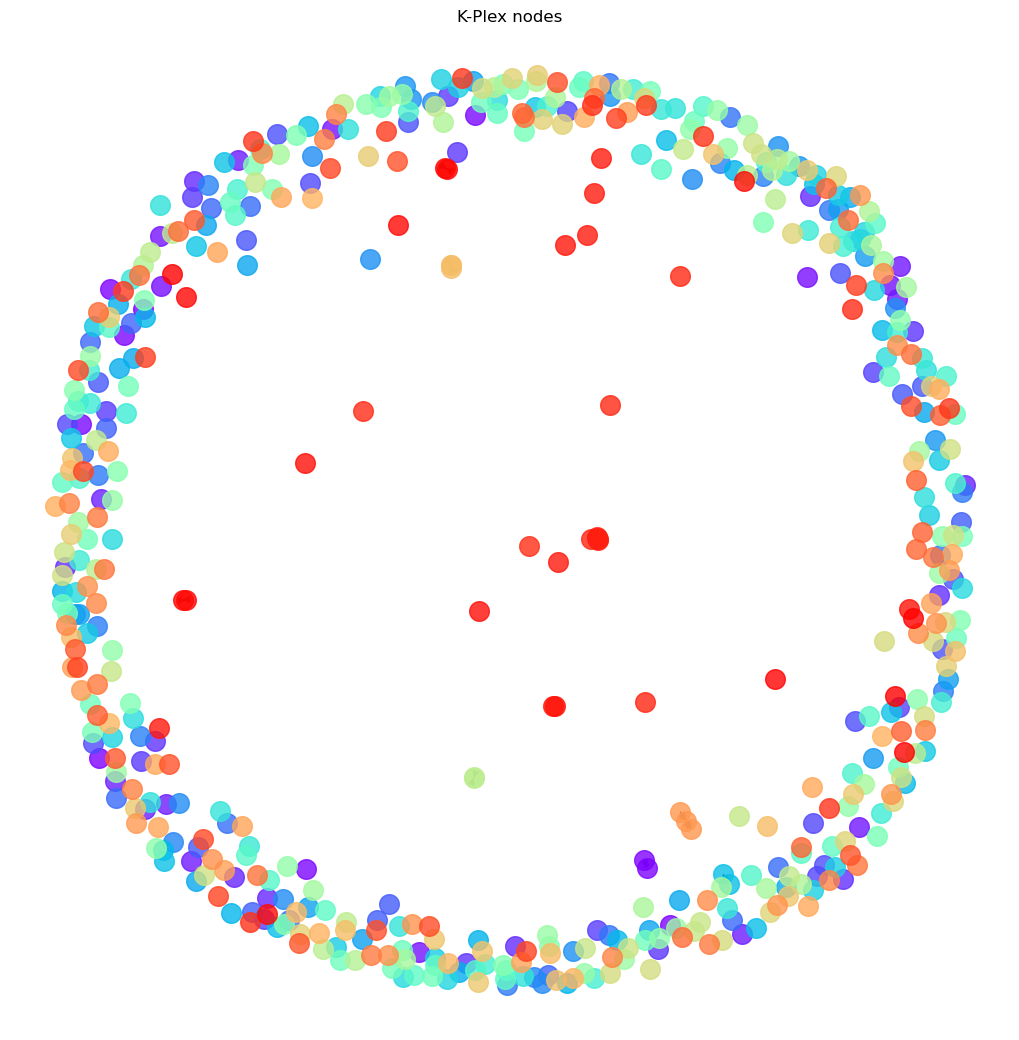

C:\Users\minda\AppData\Roaming\Python\Python311\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


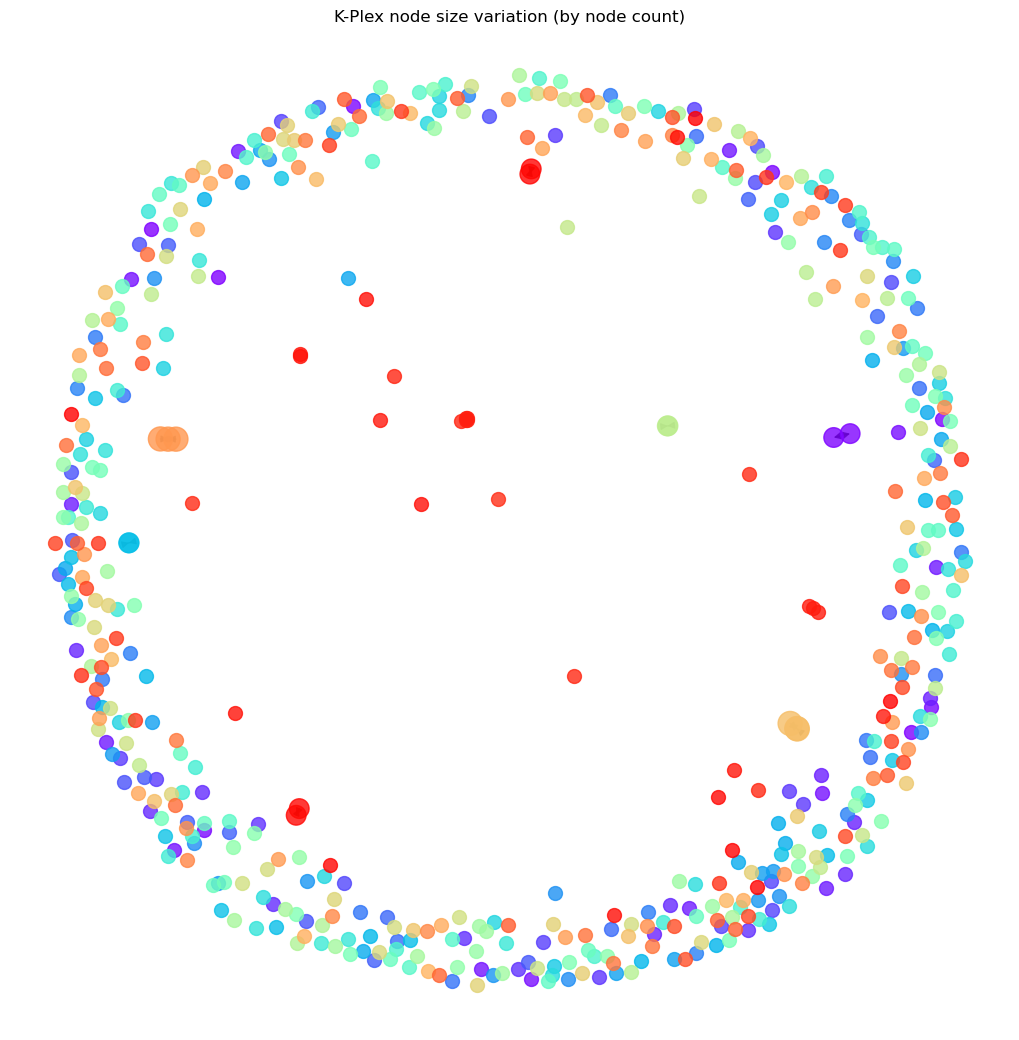

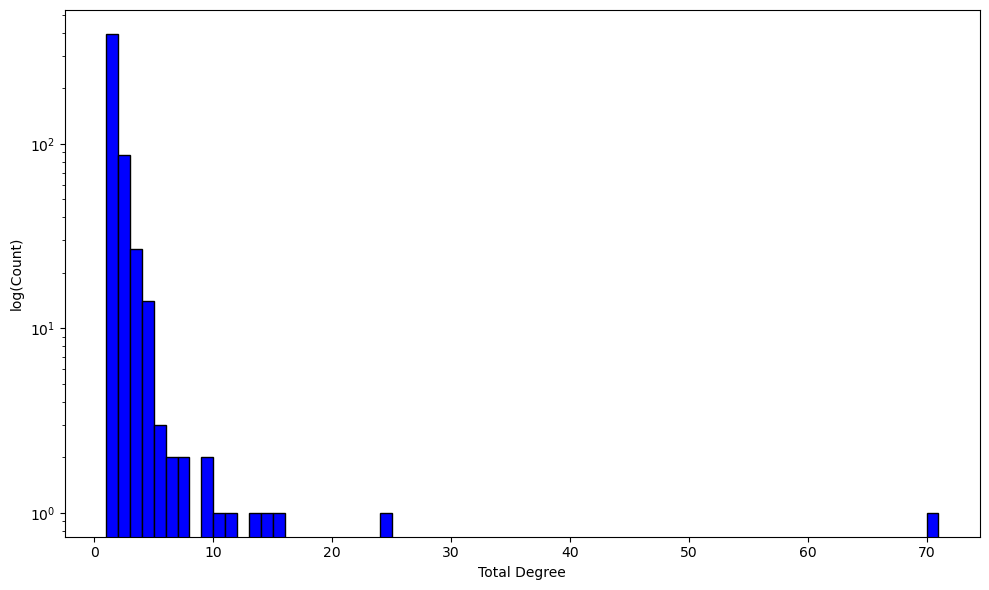

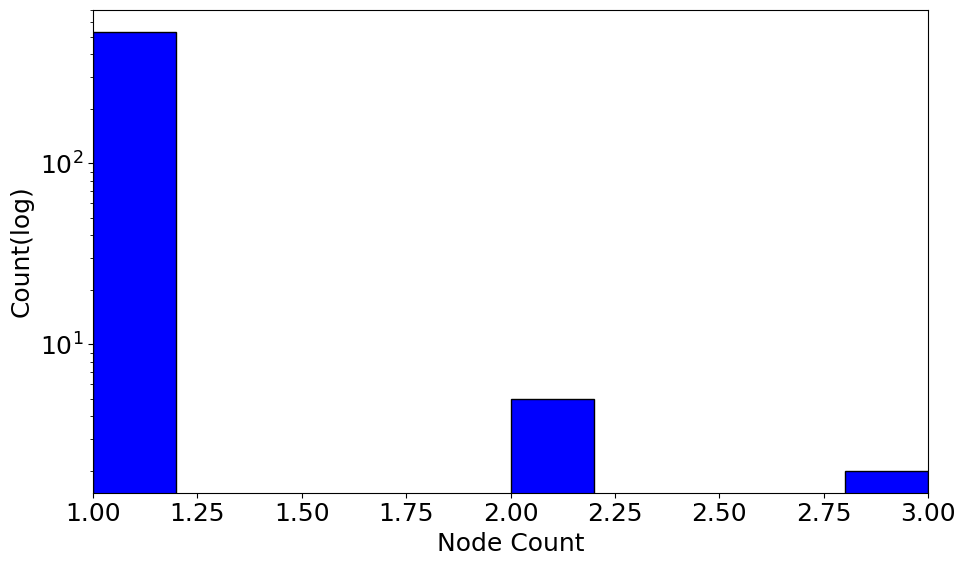

In [14]:
# Part C function call
name = "C"
k_plex_info = analyze_k_plexes(G, name)

### D) Positive and Negative Matrices

In [15]:
#Now we want to compare the result with that obtained when the sign information is ignored from the network. For this purpose, consider two graphs 
#from the original. The first one assumes only the edge of positive weights (the edge of negative weights are not represented in the network). 
#The second one assumes only the edges of negative weights (the edges of positive weights are not represented), and the negative weights are turned into positive.
#Write a script to save the adjacency matrices of the two newly created graphs into an excel file.

In [16]:
# Create a new graph with only positive weighted edges
G_positive = nx.DiGraph()
for u, v, w in G.edges(data=True):
    if w["weight"] > 0:
        G_positive.add_edge(u, v, weight=w["weight"])

# Create a new graph with only negative weighted edges, turning them positive
G_negative = nx.DiGraph()
for u, v, w in G.edges(data=True):
    if w["weight"] < 0:
        G_negative.add_edge(u, v, weight=abs(w["weight"]))


# Save adjacency matrices
adjacency_positive = nx.to_pandas_adjacency(G_positive)
adjacency_negative = nx.to_pandas_adjacency(G_negative)

In [17]:
# Saving matrices as excel files
print("Positive matrix")
print(adjacency_positive)

adjacency_positive.to_excel("data/positive_adjacency_matrix.xlsx", index=False, header=False)

print("Negative matrix")
print(adjacency_negative)

adjacency_negative.to_excel("data/negative_adjacency_matrix.xlsx", index=False, header=False)

Positive matrix
      7188  1     160   1028  309   11    594   1316  1392  1583  ...  2666  \
7188   0.0  10.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1      0.0   0.0  10.0   7.0   5.0   5.0   5.0   5.0   4.0   4.0  ...   0.0   
160    0.0  10.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1028   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
309    0.0   5.0   0.0   0.0   0.0   3.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
7452   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
7451   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3296   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6336   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3228   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      3271  1870  2578  6157  7452 

### E) Rerun of B and C on D

#### Rerun of B on D

In [18]:
positive_in_degree, positive_in_count = calculate_degrees(G_positive.in_degree())
positive_out_degree, positive_out_count = calculate_degrees(G_positive.out_degree())
negative_in_degree, negative_in_count = calculate_degrees(G_negative.in_degree())
negative_out_degree, negative_out_count = calculate_degrees(G_negative.out_degree())

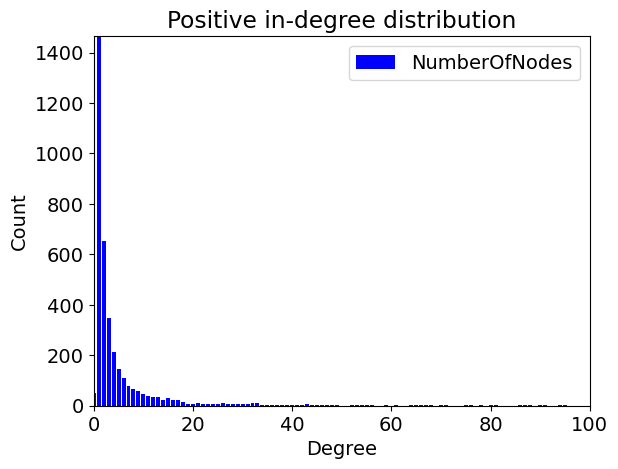

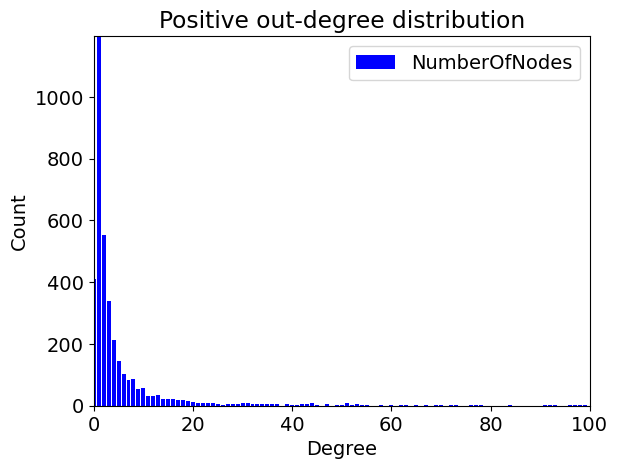

C:\Users\minda\AppData\Local\Temp\ipykernel_39632\2130378041.py:5: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


Optimal parameters: a=960.2197576396969, b=-1.4535518253135855


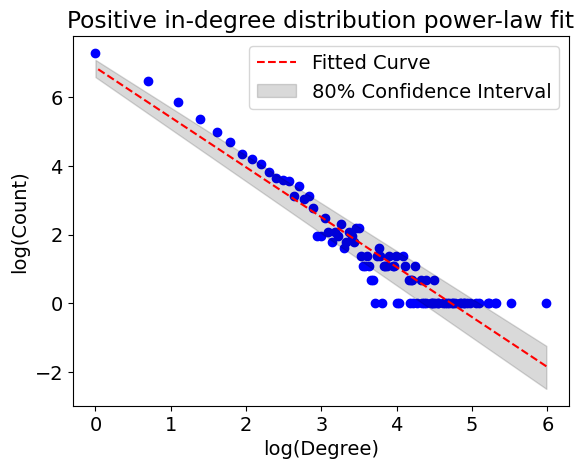

C:\Users\minda\AppData\Local\Temp\ipykernel_39632\2130378041.py:5: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


Optimal parameters: a=909.2416580777029, b=-1.4274171221293463


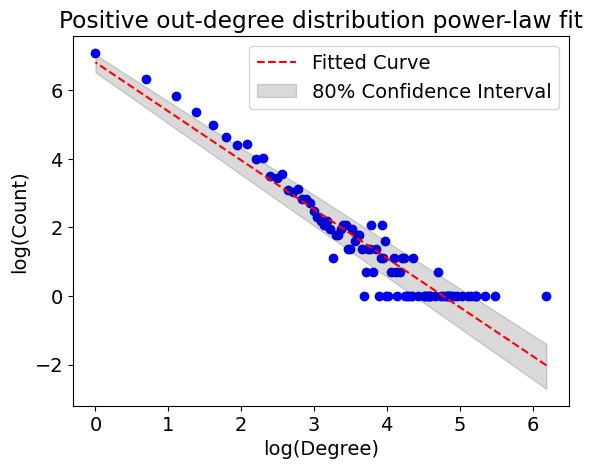

Percentage of nodes with in-degree under 10: 0.8645126255769753
Percentage of nodes with out-degree under 10: 0.8642411077925604


In [19]:
#Part E, positive weights calculations

positive_in_degree, positive_in_count = calculate_degrees(G_positive.in_degree())
plot_degree(positive_in_degree, positive_in_count, "Positive in-degree distribution", "E_B_Positive_in_degree_distribution")
positive_out_degree, positive_out_count = calculate_degrees(G_positive.out_degree())
plot_degree(positive_out_degree, positive_out_count, "Positive out-degree distribution", "E_B_Positive_out_degree_distribution")

fit_and_plot_powerlaw(positive_in_degree, positive_in_count, "Positive in-degree distribution power-law fit", "E_B_Positive_in_degree_distribution_powerlaw_fit")
fit_and_plot_powerlaw(positive_out_degree, positive_out_count, "Positive out-degree distribution power-law fit", "E_B_Positive_out_degree_distribution_powerlaw_fit")

# percentage of nodes with in / out degress under 20
positive_in_degree_under_10= sum(positive_in_count[-10:]) / sum(positive_in_count)
positive_out_degree_under_10 = sum(positive_out_count[-10:]) / sum(positive_out_count)

print(f"Percentage of nodes with in-degree under 10: {positive_in_degree_under_10}")
print(f"Percentage of nodes with out-degree under 10: {positive_out_degree_under_10}")

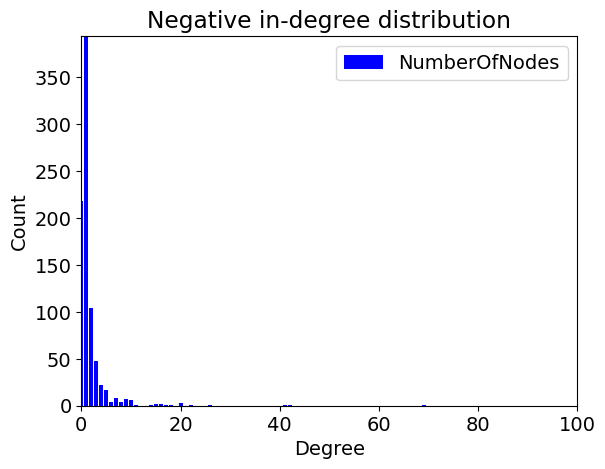

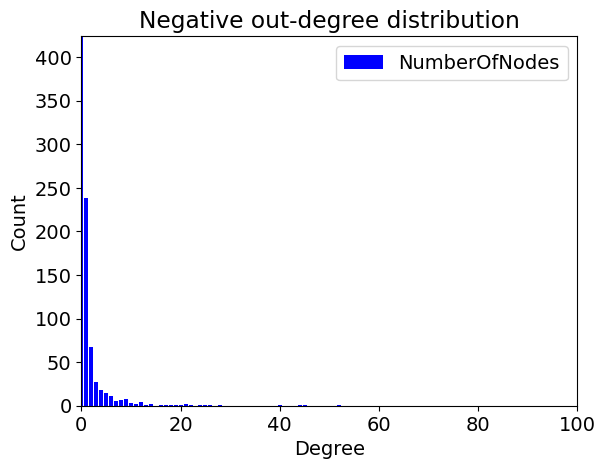

C:\Users\minda\AppData\Local\Temp\ipykernel_39632\2130378041.py:5: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


Optimal parameters: a=163.85568524025382, b=-1.5405373337394612


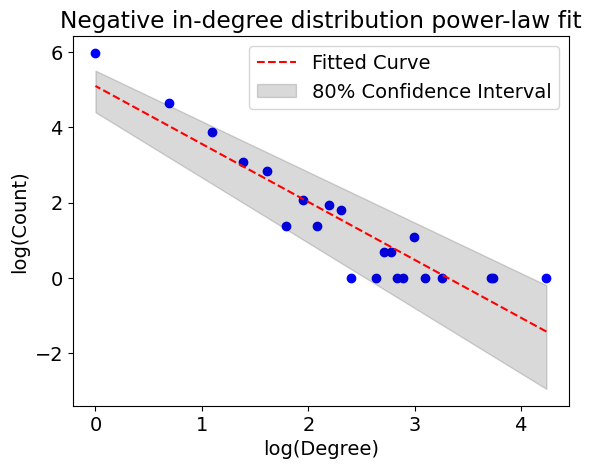

Optimal parameters: a=83.50380475258244, b=-1.2894855333108255


C:\Users\minda\AppData\Local\Temp\ipykernel_39632\2130378041.py:5: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


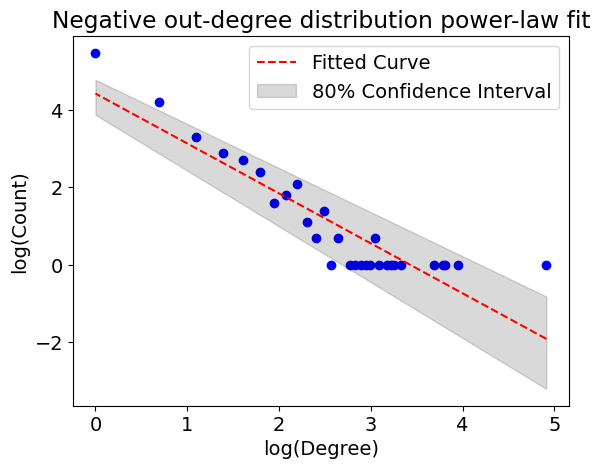

In [20]:
#Part E, negative weights calculations

negative_in_degree, negative_in_count = calculate_degrees(G_negative.in_degree())
plot_degree(negative_in_degree, negative_in_count, "Negative in-degree distribution", "E_B_Negative_in_degree_distribution")
negative_out_degree, negative_out_count = calculate_degrees(G_negative.out_degree())
plot_degree(negative_out_degree, negative_out_count, "Negative out-degree distribution", "E_B_Negative_out_degree_distribution")

fit_and_plot_powerlaw(negative_in_degree, negative_in_count, "Negative in-degree distribution power-law fit", "E_B_Negative_in_degree_distribution_powerlaw_fit")
fit_and_plot_powerlaw(negative_out_degree, negative_out_count, "Negative out-degree distribution power-law fit", "E_B_Negative_out_degree_distribution_powerlaw_fit")



In [21]:
# percentage of nodes with in / out degress under 20
negative_in_degree_under_10= sum(negative_in_count[-10:]) / sum(negative_in_count)
negative_out_degree_under_10 = sum(negative_out_count[-10:]) / sum(negative_out_count)

print(f"Percentage of nodes with in-degree under 10: {negative_in_degree_under_10}")
print(f"Percentage of nodes with out-degree under 10: {negative_out_degree_under_10}")

Percentage of nodes with in-degree under 10: 0.9740566037735849
Percentage of nodes with out-degree under 10: 0.9658018867924528


In [22]:
# POSITIVE
#Additionally, calculate the average clustering coefficient and diameter.
positive_average_clustering_coefficient = nx.average_clustering(G_positive)
print("Average positive clustering coefficient: ", positive_average_clustering_coefficient)

#identify biggest strongly connected component first
positive_strongly_connected_components = nx.strongly_connected_components(G_positive)
positive_biggest_strongly_connected_component = max(positive_strongly_connected_components, key=len)
positive_G_strongly_connected = G_positive.subgraph(positive_biggest_strongly_connected_component)
positive_diameter = nx.diameter(positive_G_strongly_connected)
print("Positive Diameter: ", positive_diameter)

# NEGATIVE
#Additionally, calculate the average clustering coefficient and diameter.
negative_average_clustering_coefficient = nx.average_clustering(G_negative)
print("Average negative clustering coefficient: ", negative_average_clustering_coefficient)

#identify biggest strongly connected component first
negative_strongly_connected_components = nx.strongly_connected_components(G_negative)
negative_biggest_strongly_connected_component = max(negative_strongly_connected_components, key=len)
negative_G_strongly_connected = G_negative.subgraph(negative_biggest_strongly_connected_component)
negative_diameter = nx.diameter(negative_G_strongly_connected)
print("Negative Diameter: ", negative_diameter)


Average positive clustering coefficient:  0.1487400608700056
Positive Diameter:  10
Average negative clustering coefficient:  0.02189178862052009
Negative Diameter:  9


In [23]:
print("Positive")
print(f"dropped nodes: {len(G_positive.nodes) - len(positive_biggest_strongly_connected_component)}")
print(f"dropped edges: {len(G_positive.edges)-len(positive_G_strongly_connected.edges)}")
print(f"nodes: {len(G_positive.nodes)}")
print(f"edges: {len(G_positive.edges)}")

Positive
dropped nodes: 491
dropped edges: 769
nodes: 3683
edges: 22650


In [24]:
print("Negative")
print(f"dropped nodes: {len(G_negative.nodes) - len(negative_biggest_strongly_connected_component)}")
print(f"dropped edges: {len(G_negative.edges)-len(negative_G_strongly_connected.edges)}")
print(f"nodes: {len(G_negative.nodes)}")
print(f"edges: {len(G_negative.edges)}")

Negative
dropped nodes: 737
dropped edges: 1133
nodes: 848
edges: 1536


In [25]:
N = nx.DiGraph()
N = G_negative
P = nx.DiGraph()
P = G_positive

In [26]:
#do same but treat graph as undirected for negative
connected_components = nx.connected_components(N.to_undirected())
biggest_connected_component = max(connected_components, key=len)
N_connected = N.to_undirected().subgraph(biggest_connected_component)
diameter = nx.diameter(N_connected)
print("Diameter (undirected): ", diameter)

print(f"dropped nodes: {len(N.nodes) - len(biggest_connected_component)}")
print(f"dropped edges: {len(N.to_undirected().edges)-len(N_connected.edges)}")
print(f"nodes: {len(N.nodes)}")
print(f"edges: {len(N.to_undirected().edges)}")

Diameter (undirected):  11
dropped nodes: 94
dropped edges: 52
nodes: 848
edges: 1400


In [27]:
#do same but treat graph as undirected for positive
connected_components = nx.connected_components(P.to_undirected())
biggest_connected_component = max(connected_components, key=len)
P_connected = P.to_undirected().subgraph(biggest_connected_component)
diameter = nx.diameter(P_connected)
print("Diameter (undirected): ", diameter)

print(f"dropped nodes: {len(P.nodes) - len(biggest_connected_component)}")
print(f"dropped edges: {len(P.to_undirected().edges)-len(P_connected.edges)}")
print(f"nodes: {len(P.nodes)}")
print(f"edges: {len(P.to_undirected().edges)}")

Diameter (undirected):  10
dropped nodes: 13
dropped edges: 7
nodes: 3683
edges: 12972


#### Rerun of C on D

476


C:\Users\minda\AppData\Roaming\Python\Python311\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


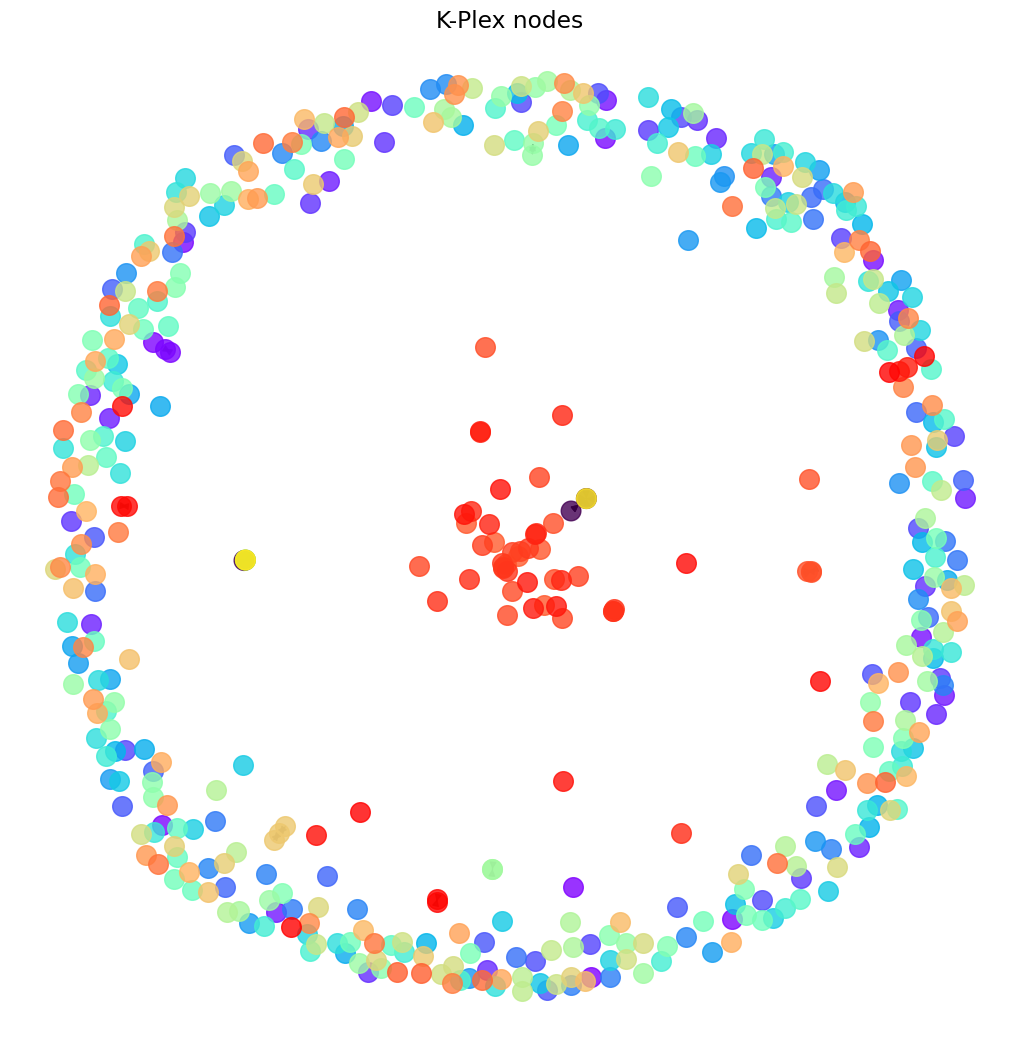

C:\Users\minda\AppData\Roaming\Python\Python311\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


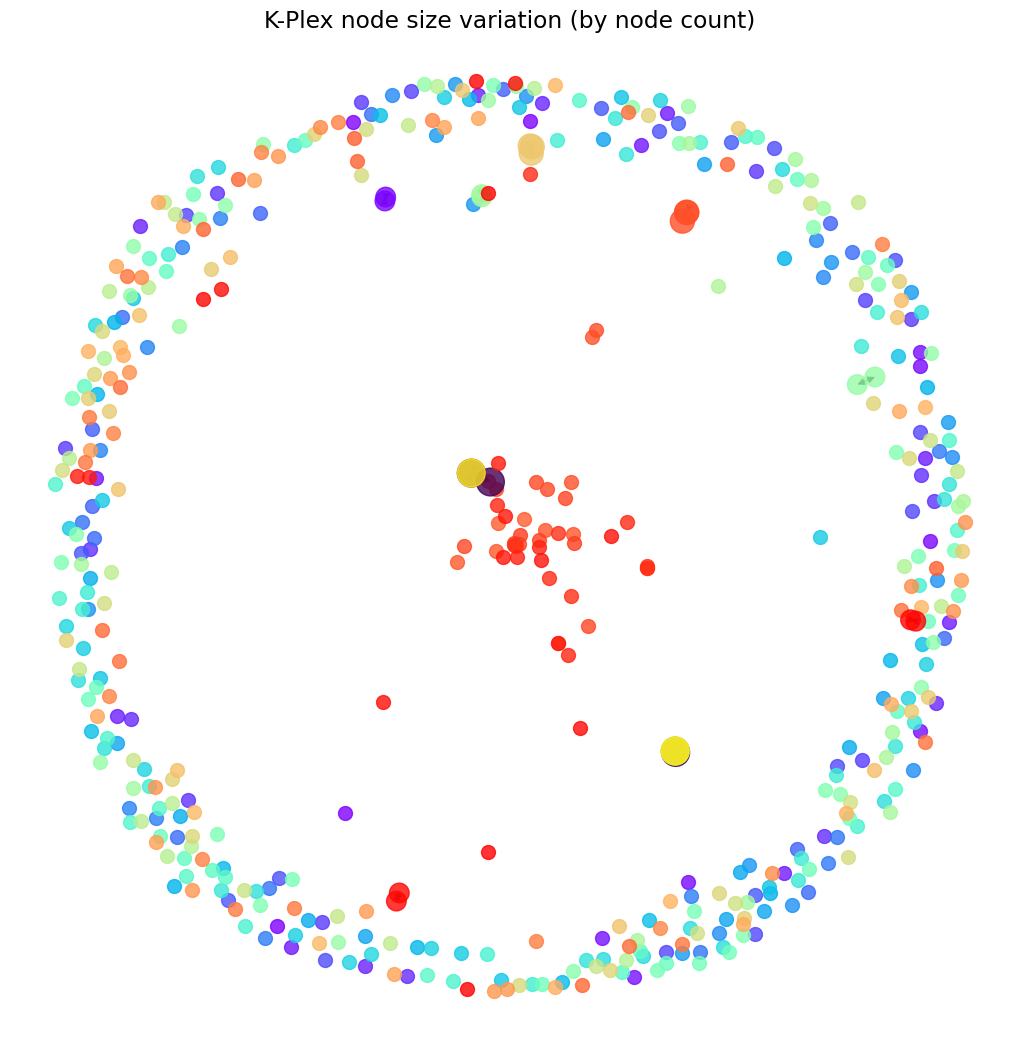

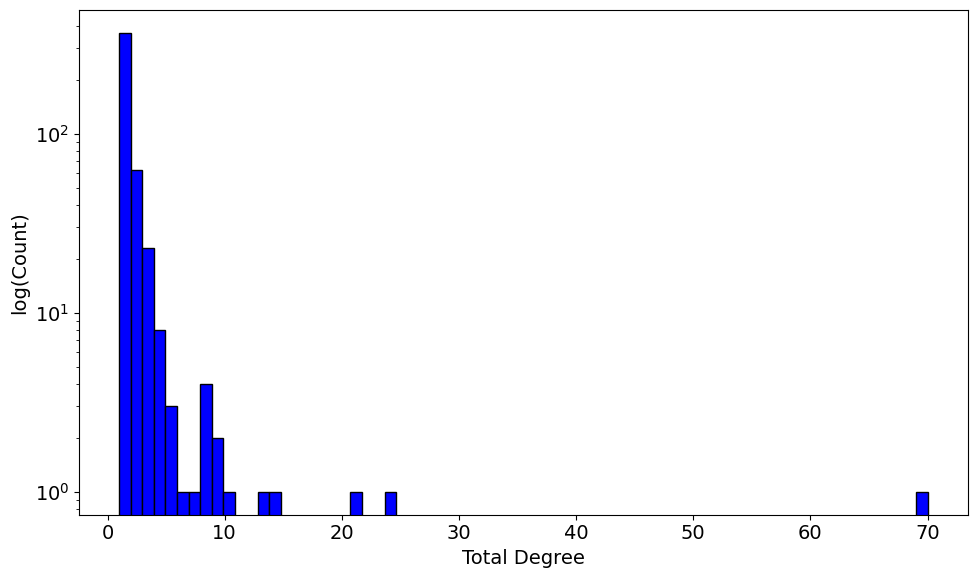

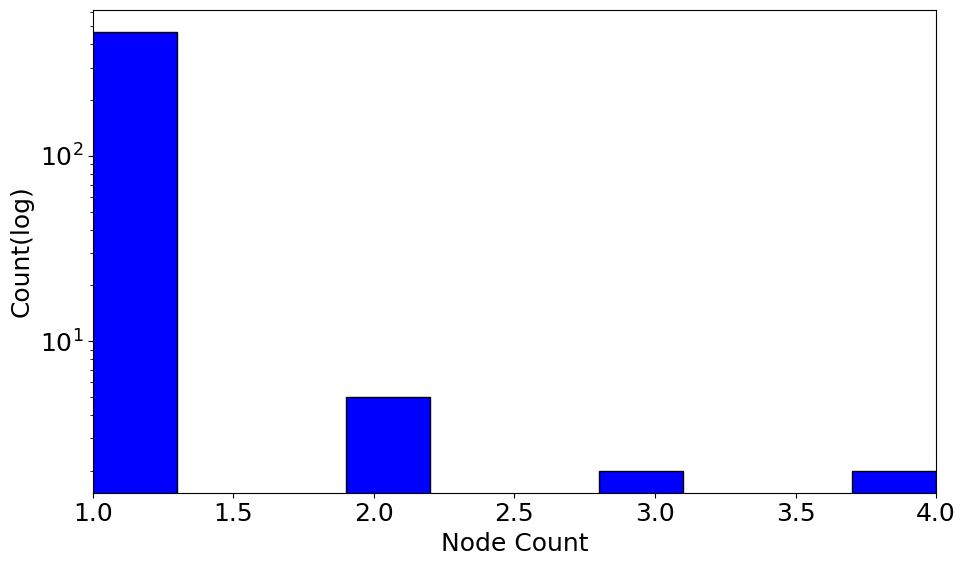

In [28]:
# Part C function call for part E, positive
name = "E_C_Positive"
positive_k_plex_info = analyze_k_plexes(G_positive, name)

713


C:\Users\minda\AppData\Roaming\Python\Python311\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


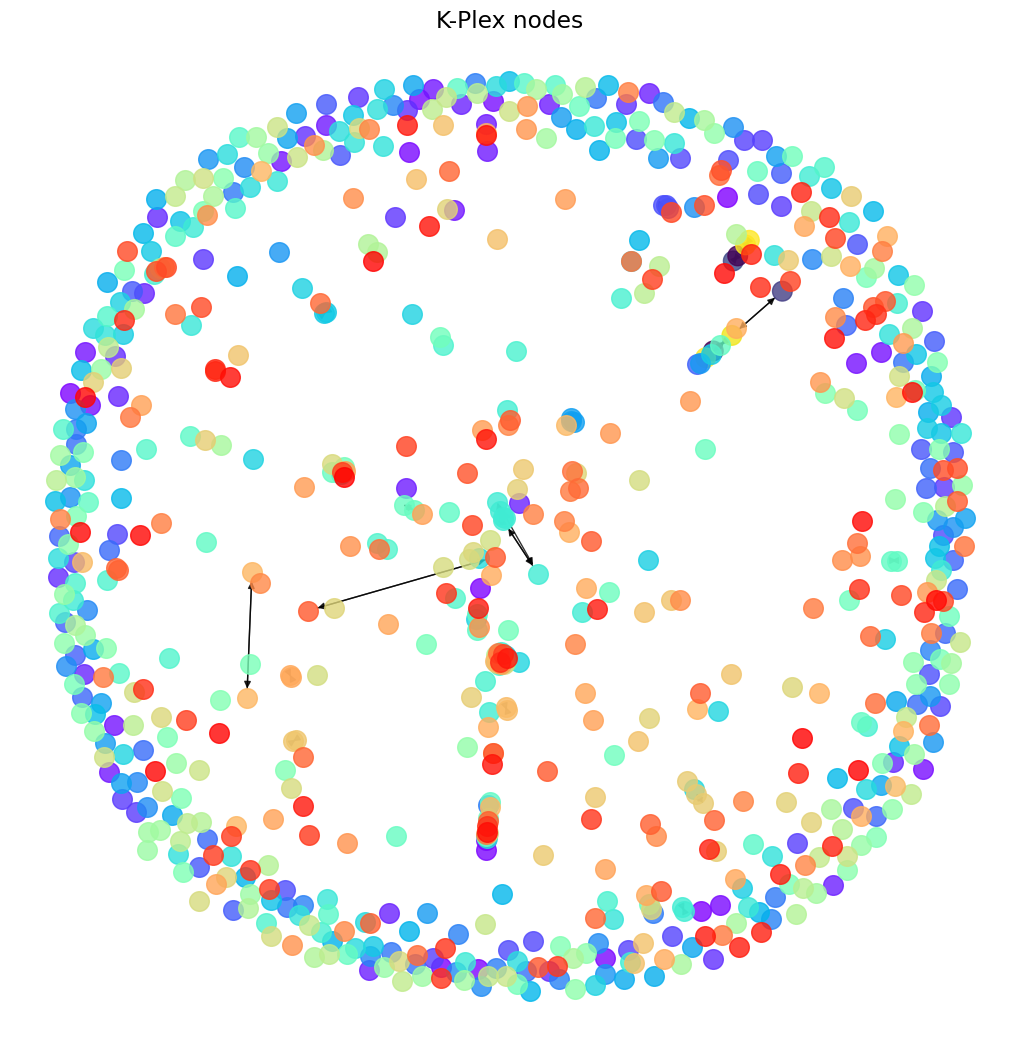

C:\Users\minda\AppData\Roaming\Python\Python311\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


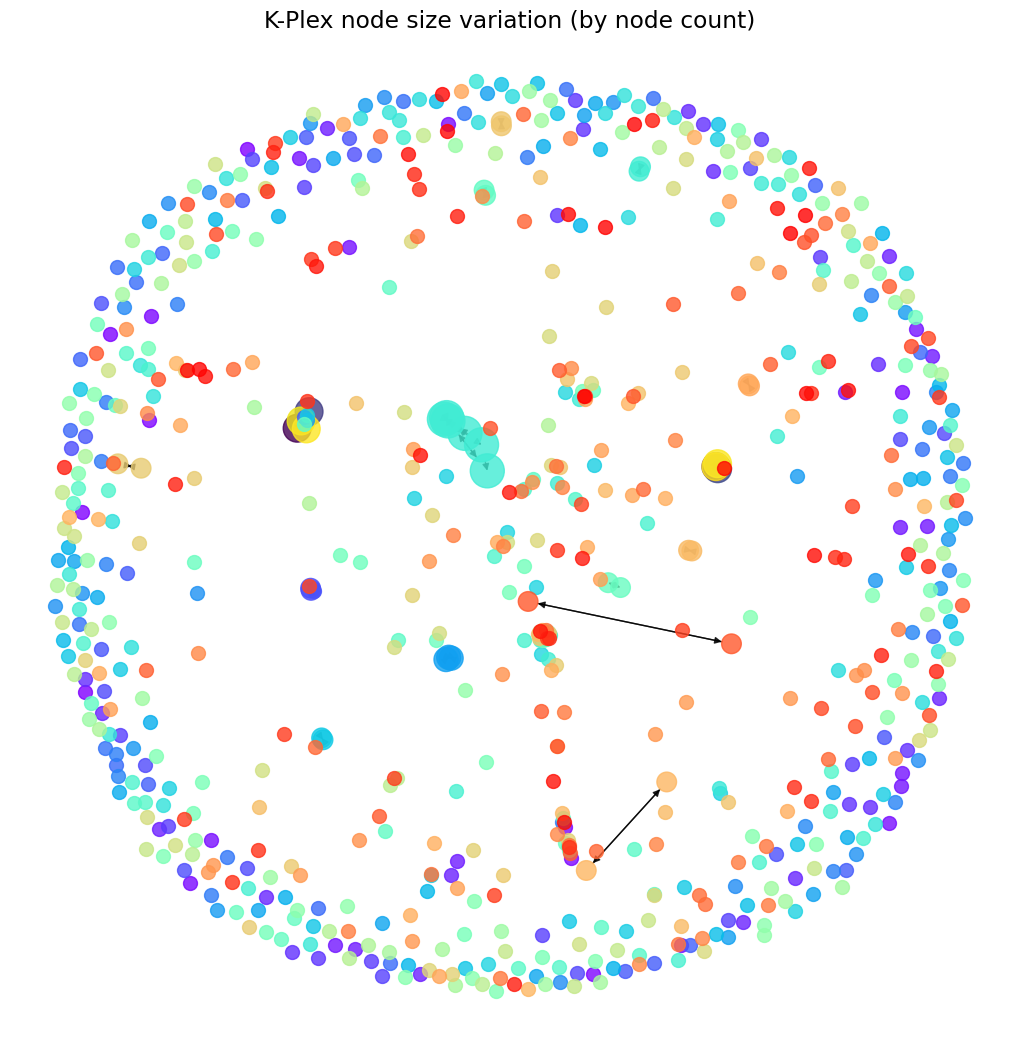

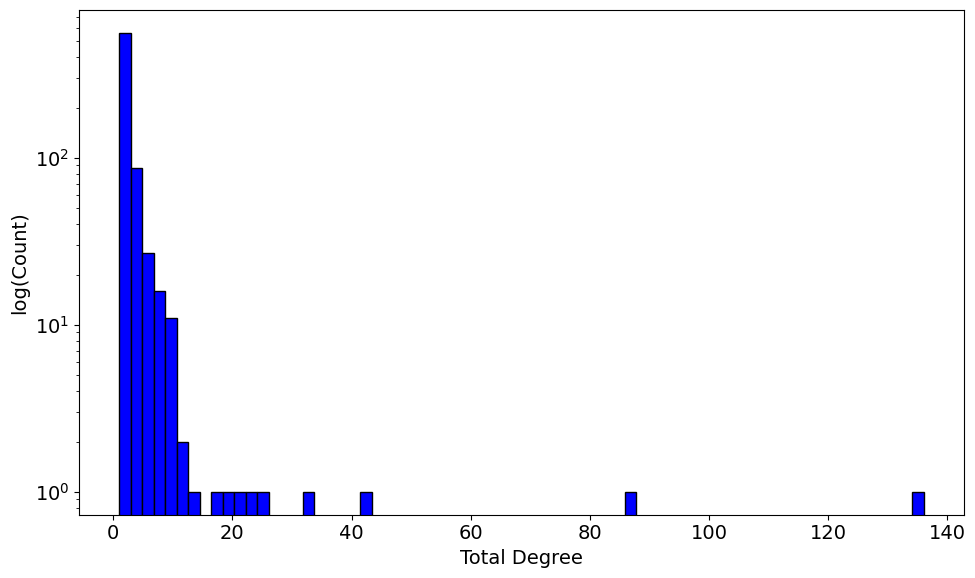

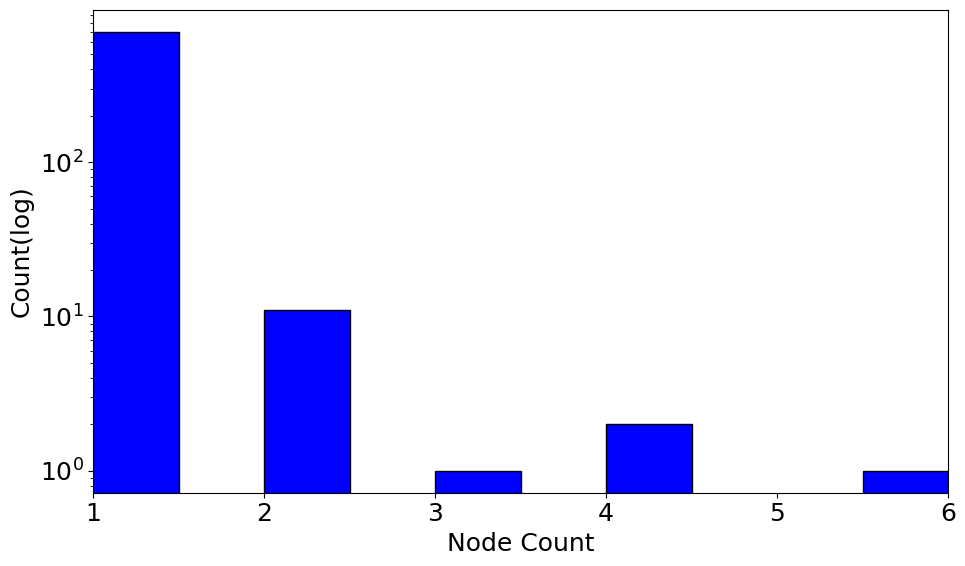

In [29]:
# Part C function call for part E, negative
name = "E_C_Negative"
negative_k_plex_info = analyze_k_plexes(G_negative, name)

#### Exploration of B on D

In [30]:
# percentage of nodes with in / out degress under 20
in_degree_under_10= sum(in_count[-10:]) / sum(in_count)
out_degree_under_10 = sum(out_count[-10:]) / sum(out_count)

print(f"Percentage of nodes with in-degree under 10: {in_degree_under_10}")
print(f"Percentage of nodes with out-degree under 10: {out_degree_under_10}")

NameError: name 'in_count' is not defined

In [ ]:
def remove_outliers(degree, count):
    # Prepare the data for Isolation Forest
    X = np.column_stack((degree, count))

    # Initialize the Isolation Forest model
    clf = IsolationForest(contamination=0.1)

    # Fit the model and predict outliers
    preds = clf.fit_predict(X)

    # Filter the inliers
    X_inliers = X[preds == 1]

    return X_inliers

def fit_and_plot_powerlaw3(degree, count, title, save_path):
    degree, count = np.log(degree)[:-1], np.log(count)[:-1]
    popt_log, pcov_log = curve_fit(linlaw, degree, count)

    # Calculate standard errors of the parameters
    sigma_ab = np.sqrt(np.diagonal(pcov_log))

    # Calculate critical value for an 80% confidence interval
    z = norm.ppf(0.9)  # for an 80% confidence interval

    # Calculate confidence bounds
    bound_upper = linlaw(degree, *(popt_log + z * sigma_ab))
    bound_lower = linlaw(degree, *(popt_log - z * sigma_ab))

    # Calculate the percentage of nodes that fit within the 80% confidence interval before outlier removal
    in_interval_before = np.sum((count >= bound_lower) & (count <= bound_upper))
    total_nodes_before = len(count)
    ratio_in_interval_before = in_interval_before / total_nodes_before

    print(f"Percentage of nodes within the 80% confidence interval before outlier removal: {ratio_in_interval_before*100}%")

    # Remove outliers
    X_inliers = remove_outliers(np.exp(degree), np.exp(count))
    degree_inliers, count_inliers = np.log(X_inliers[:, 0]), np.log(X_inliers[:, 1])

    # Fit the model to the inliers
    popt_log_inliers, pcov_log_inliers = curve_fit(linlaw, degree_inliers, count_inliers)

    # Calculate confidence bounds for the inliers
    bound_upper_inliers = linlaw(degree_inliers, *(popt_log_inliers + z * sigma_ab))
    bound_lower_inliers = linlaw(degree_inliers, *(popt_log_inliers - z * sigma_ab))

    # Calculate the percentage of nodes that fit within the 80% confidence interval after outlier removal
    in_interval_after = np.sum((count_inliers >= bound_lower_inliers) & (count_inliers <= bound_upper_inliers))
    total_nodes_after = len(count_inliers)
    ratio_in_interval_after = in_interval_after / total_nodes_after

    print(f"Percentage of nodes within the 80% confidence interval after outlier removal: {ratio_in_interval_after*100}%")

    print(f"Optimal parameters: a={popt_log[0]}, b={popt_log[1]}")
    plt.scatter(degree, count, color='b')
    plt.plot(degree, linlaw(degree, *popt_log), 'r--', label = "Fitted Curve")
    plt.fill_between(degree, bound_lower, bound_upper, color='black', alpha=0.15, label='80% Confidence Interval')  # plotting the confidence intervals
    plt.xlabel("log(Degree)")
    plt.ylabel("log(Count)")
    plt.legend(loc='best')
    plt.savefig(f"plots/{save_path}.pdf")
    plt.title(title)
    plt.show()



In [ ]:
fit_and_plot_powerlaw3(in_degree, in_count, "In-degree distribution power-law fit with isolation forest", "B_Extra_Forest_in_degree_distribution_powerlaw_fit")
fit_and_plot_powerlaw3(out_degree, out_count, "Out-degree distribution power-law fit with isolation forest", "B_Extra_Forest_out_degree_distribution_powerlaw_fit")

In [ ]:
fit_and_plot_powerlaw3(negative_in_degree, negative_in_count, "Negative in-degree distribution power-law fit with isolation forest", "E_B_Extra_Forest_Negative_in_degree_distribution_powerlaw_fit")
fit_and_plot_powerlaw3(negative_out_degree, negative_out_count, "Negative out-degree distribution power-law fit with isolation forest", "E_B_Extra_Forest_Negative_out_degree_distribution_powerlaw_fit")

In [ ]:
fit_and_plot_powerlaw3(positive_in_degree, positive_in_count, "Positive in-degree distribution power-law fit with isolation forest", "E_B_Extra_Forest_Positive_in_degree_distribution_powerlaw_fit")
fit_and_plot_powerlaw3(positive_out_degree, positive_out_count, "Positive out-degree distribution power-law fit with isolation forest", "E_B_Extra_Forest_Positive_out_degree_distribution_powerlaw_fit")

#### Exploration of C on D

In [ ]:
def plex(G, B, name):

    # Largest strongly connected component
    def largest_strongly_connected_component(graph):
        components = list(nx.strongly_connected_components(graph))
        largest_component = max(components, key=len)
        return graph.subgraph(largest_component)

    # Calculate k-value based on the minimum degree
    def calculate_k(subgraph):
        min_degree = min(dict(subgraph.degree()).values())
        k = max(1, min(len(subgraph) - min_degree, len(subgraph) // 2))
        return k

    # Find k-plexes in the directed graph
    def find_k_plex(graph, k):
        components = list(nx.strongly_connected_components(graph))
        k_plexes = []

        for component in components:
            subgraph = graph.subgraph(component)
            if all(degree >= (len(subgraph) - k) for _, degree in subgraph.degree()):
                k_plexes.append(subgraph)

        return k_plexes
    
    # Find k-plexes
    def find_k_plex(graph, min_k):
        components = list(nx.strongly_connected_components(graph))
        k_plexes = []

        for component in components:
            subgraph = graph.subgraph(component)
            k = max(min_k, calculate_k(subgraph))  # Use the larger of min_k and the calculated k
            if all(degree >= (len(subgraph) - k) for _, degree in subgraph.degree()):
                k_plexes.append(subgraph)

        return k_plexes
    
#--------------------------------------------
# NEW for Part E 

    # Histogram to compare amount of communities
    def compare_community_size_distribution(positive_communities, negative_communities):

        positive_sizes = [len(c) for c in positive_communities]
        negative_sizes = [len(c) for c in negative_communities]

        all_sizes = positive_sizes + negative_sizes
        min_size = min(all_sizes)
        max_size = max(all_sizes)

        # Create a consistent range of bins
        bins = np.linspace(min_size, max_size, num=12)
        plt.figure(figsize=(10, 6))
        plt.hist(positive_sizes, bins=bins, alpha=0.5, color = "blue", label='Positive Network')
        plt.hist(negative_sizes, bins=bins, alpha=0.5, color = "yellow", label='Negative Network')
        plt.xlabel('Community Size')
        plt.ylabel('Number of Communities')
        plt.yscale('log')
        plt.legend(loc='upper right')
        filename = "plots/" + name + "_k_plex_compared_histogram_log.pdf"
        plt.savefig(filename)
        plt.show()

    # Venn diagram to see Pos+Neg community overlap
    def visualize_node_overlap(positive_communities, negative_communities):
        positive_nodes = set().union(*positive_communities)
        negative_nodes = set().union(*negative_communities)

        venn2([positive_nodes, negative_nodes], set_labels = ('Positive Network', 'Negative Network'), set_colors = ("green", "red"))
        filename = "plots/" + name + "_k_plex_venn.pdf"
        plt.savefig(filename)
        plt.show()

    # Function to find and return the overlapping nodes to be used later
    def get_exclusive_communities(all_communities, overlapping_nodes):
        exclusive_communities = []
        for community in all_communities:
            # Create a new subgraph for each community excluding the overlapping nodes
            exclusive_nodes = set(community.nodes()) - overlapping_nodes
            if exclusive_nodes:  # Check if the community still has nodes after excluding
                exclusive_community = community.subgraph(exclusive_nodes).copy()
                exclusive_communities.append(exclusive_community)
        return exclusive_communities

    # Function to plot graph with varying node sizes based on k-plex node count
    def plot_overlap(graph, positive_nodes, negative_nodes, overlapping_nodes, k_plexes):
        pos = nx.spring_layout(graph)  # Layout for the graph
        plt.figure(figsize=(10, 10))
        # Define node sizes based on the count of nodes in k-plexes
        k_plex_node_count = {node: len(k_plex.nodes()) for k_plex in k_plexes for node in k_plex.nodes()}

        # Draw nodes for positive, negative, and overlapping nodes with new node sizes
        nx.draw_networkx_nodes(
            graph,
            pos,
            nodelist=positive_nodes,
            node_color='green',
            alpha=0.3,
            node_size=[k_plex_node_count[node] * 100 for node in positive_nodes]  # Scale based on k-plex size
        )
        nx.draw_networkx_nodes(
            graph,
            pos,
            nodelist=negative_nodes,
            node_color='red',
            alpha=0.3,
            node_size=[k_plex_node_count[node] * 100 for node in negative_nodes]  # Scale based on k-plex size
        )
        nx.draw_networkx_nodes(
            graph,
            pos,
            nodelist=overlapping_nodes,
            node_color='blue',
            alpha=0.3,
            node_size=[k_plex_node_count[node] * 100 for node in overlapping_nodes]  # Scale based on k-plex size
        )
        plt.axis('off')
        plt.tight_layout()
        # Save and display the plot
        filename = "plots/" + name + "_all_overlap_k_plex.pdf"
        plt.savefig(filename)
        plt.show()
        
    def plot_degree_histogram(graph, k_plexes):
        k_plex_sizes = [len(k_plex.nodes()) for k_plex in k_plexes]

        # Plot the histogram for the k-plex sizes
        plt.figure(figsize=(10, 6))
        plt.hist(k_plex_sizes, color='blue', edgecolor='black')
        plt.xlabel("Node Count")
        plt.xlim(0.5, max(k_plex_sizes))
        plt.ylabel("Count")
        plt.yscale("log")
        plt.tight_layout()
        plt.rcParams.update({'font.size': 18})
        # Save the plot to a file
        filename = "plots/" + name + "Positive_k_plex_histogram_nodes.pdf"
        plt.savefig(filename)
        plt.show()
        plt.rcParams.update({'font.size': 14})
    # Conducting analysis
    # Split for positive and negative network
    largest_component_G = largest_strongly_connected_component(G)
    largest_component_B = largest_strongly_connected_component(B)

    # Testing purposes, experimented with both k-values for both networks, unsatisfactory results
    k = min(calculate_k(largest_component_G), calculate_k(largest_component_B))
    print(calculate_k(largest_component_G))
    print(calculate_k(largest_component_B))

    # Find k-plexes for both networks
    k_plexes_G = find_k_plex(G, calculate_k(largest_component_G))
    k_plexes_B = find_k_plex(B, calculate_k(largest_component_B))

    # Draw histogram
    compare_community_size_distribution(k_plexes_B, k_plexes_G)
    
    # Draw venn diagram
    visualize_node_overlap(k_plexes_B, k_plexes_G)

    # Get the overlapping nodes
    positive_nodes = set().union(*k_plexes_G)
    negative_nodes = set().union(*k_plexes_B)
    overlapping_nodes = positive_nodes & negative_nodes

    # Get exclusive communities for each network
    excl_k_plexes_G = get_exclusive_communities(k_plexes_G, overlapping_nodes)
    excl_k_plexes_B = get_exclusive_communities(k_plexes_B, overlapping_nodes)

    # New names for saving files
    name_G = name + "_removed_negative_"
    name_B = name + "_removed_positive_"
    plot_degree_histogram(B, k_plexes_B)
    plot_degree_histogram(G, k_plexes_G)
    # Recombining the datasets to have a single base variable for plotting
    G_composed = nx.compose(G, B)
    k_plexes = k_plexes_G + k_plexes_B
    # Plot the three different overlaps
    plot_overlap(G_composed, positive_nodes, negative_nodes, overlapping_nodes, k_plexes)
    
    return (k, k_plexes_G)

In [ ]:
name = "E_C_Network_Overlaps"
comparison_plex = plex(G_negative, G_positive, name)

### F) Link Sign Prediction

#### Create Feature DF

In [127]:
feature_df = graph_df[["source", "target", "weight"]]
#create edge column with tuple of source and target
feature_df["edge"] = list(zip(feature_df["source"], feature_df["target"]))
feature_df

source  target  weight          edge
0        7188       1      10     (7188, 1)
1         430       1      10      (430, 1)
2        3134       1      10     (3134, 1)
3        3026       1      10     (3026, 1)
4        3010       1      10     (3010, 1)
...       ...     ...     ...           ...
24181    7604    7601      10  (7604, 7601)
24182    7601    7604      10  (7601, 7604)
24183    7604    7602      10  (7604, 7602)
24184    7602    7604      10  (7602, 7604)
24185    7604    7603     -10  (7604, 7603)

[24186 rows x 4 columns]

In [117]:
#calcualte edge betweenness
edge_betweenness = nx.edge_betweenness_centrality(G, seed = 42)

In [125]:
#calcualte edge betweenness with weight
edge_betweenness_weighted = nx.edge_betweenness_centrality(G, weight = "weight", seed = 42)

In [ ]:
#calcualte edge betweenness with weight
edge_betweenness = nx.edge_betweenness_centrality(G, seed = 42)

In [118]:
#calculate degree centrality 
degree_centrality = nx.degree_centrality(G)

In [119]:
#calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality

{7188: 0.0,
 1: 0.3587718223102824,
 430: 0.2441359654296969,
 3134: 0.27113369809780447,
 3026: 0.25328500151903444,
 3010: 0.25328500151903444,
 804: 0.2756907909201678,
 160: 0.2674623921828729,
 95: 0.3372463757150159,
 377: 0.25365148370607593,
 888: 0.25853793960934535,
 89: 0.3101711939424735,
 1901: 0.25328500151903444,
 161: 0.2908116233096721,
 256: 0.3002438564356441,
 351: 0.27978833983259727,
 3329: 0.25328500151903444,
 3341: 0.25328500151903444,
 649: 0.28223768432499374,
 1583: 0.25328500151903444,
 87: 0.3096233697783185,
 37: 0.30948671596841965,
 309: 0.2946919633139092,
 821: 0.2618200417083718,
 1496: 0.25650462796724166,
 637: 0.27631544742604547,
 964: 0.2762610171202391,
 594: 0.2641128160849141,
 2249: 0.25328500151903444,
 554: 0.2678966673182223,
 20: 0.3192440367427484,
 2227: 0.25328500151903444,
 1315: 0.2533994133907117,
 519: 0.2847881111607054,
 1316: 0.25328500151903444,
 2149: 0.2538580963726842,
 1724: 0.2618444834598383,
 18: 0.3120344984783388,
 57

In [128]:
#add edge_betweenness to feature_df
feature_df["edge_betweenness"] = feature_df["edge"].map(edge_betweenness)

#add weighted weighted_edge betweenness
feature_df["edge_betweenness_weighted"] = feature_df["edge"].map(edge_betweenness_weighted)

#add degree centrality to feature_df
feature_df["degree_centrality_source"] = feature_df["source"].map(degree_centrality)
feature_df["degree_centrality_target"] = feature_df["target"].map(degree_centrality)
feature_df["degree_centrality"] = (feature_df["degree_centrality_source"] + feature_df["degree_centrality_target"]) / 2

#add closeness centrality to feature_df
feature_df["closeness_centrality_source"] = feature_df["source"].map(closeness_centrality)
feature_df["closeness_centrality_target"] = feature_df["target"].map(closeness_centrality)
feature_df["closeness_centrality"] = (feature_df["closeness_centrality_source"] + feature_df["closeness_centrality_target"]) / 2

#add sign to feature_df
feature_df["sign"] = np.sign(feature_df['weight'])

#save df
#feature_df.to_csv("data/feature_df.csv", index=False)
feature_df

source  target  weight          edge  edge_betweenness  \
0        7188       1      10     (7188, 1)          0.000262   
1         430       1      10      (430, 1)          0.000416   
2        3134       1      10     (3134, 1)          0.000111   
3        3026       1      10     (3026, 1)          0.000262   
4        3010       1      10     (3010, 1)          0.000262   
...       ...     ...     ...           ...               ...   
24181    7604    7601      10  (7604, 7601)          0.000019   
24182    7601    7604      10  (7601, 7604)          0.000007   
24183    7604    7602      10  (7604, 7602)          0.000017   
24184    7602    7604      10  (7602, 7604)          0.000005   
24185    7604    7603     -10  (7604, 7603)          0.000160   

       edge_betweenness_weighted  degree_centrality_source  \
0                       0.000248                  0.000264   
1                       0.000000                  0.003966   
2                       0.000000                  0.001851   
3                       0.000247                  0.000529   
4                       0.000247                  0.000529   
...                          ...                       ...   
24181                   0.000000                  0.024855   
24182                   0.000000                  0.007139   
24183                   0.000000                  0.024855   
24184                   0.000000                  0.007932   
24185                   0.034034                  0.024855   

       degree_centrality_target  degree_centrality  \
0                      0.234796           0.117530   
1                      0.234796           0.119381   
2                      0.234796           0.118324   
3                      0.234796           0.117663   
4                      0.234796           0.117663   
...                         ...                ...   
24181                  0.007139           0.015997   
24182                  0.024855           0.015997   
24183                  0.007932           0.016393   
24184                  0.024855           0.016393   
24185                  0.042041           0.033448   

       closeness_centrality_source  closeness_centrality_target  \
0                         0.000000                     0.358772   
1                         0.244136                     0.358772   
2                         0.271134                     0.358772   
3                         0.253285                     0.358772   
4                         0.253285                     0.358772   
...                            ...                          ...   
24181                     0.318664                     0.279984   
24182                     0.279984                     0.318664   
24183                     0.318664                     0.283694   
24184                     0.283694                     0.318664   
24185                     0.318664                     0.327176   

       closeness_centrality  sign  
0                  0.179386     1  
1                  0.301454     1  
2                  0.314953     1  
3                  0.306028     1  
4                  0.306028     1  
...                     ...   ...  
24181              0.299324     1  
24182              0.299324     1  
24183              0.301179     1  
24184              0.301179     1  
24185              0.322920    -1  

[24186 rows x 13 columns]

#### Load Feature DF

In [56]:
feature_df = pd.read_csv("data/feature_df.csv")
feature_df

source  target  weight          edge  edge_betweenness  \
0        7188       1      10     (7188, 1)          0.000262   
1         430       1      10      (430, 1)          0.000416   
2        3134       1      10     (3134, 1)          0.000111   
3        3026       1      10     (3026, 1)          0.000262   
4        3010       1      10     (3010, 1)          0.000262   
...       ...     ...     ...           ...               ...   
24181    7604    7601      10  (7604, 7601)          0.000019   
24182    7601    7604      10  (7601, 7604)          0.000007   
24183    7604    7602      10  (7604, 7602)          0.000017   
24184    7602    7604      10  (7602, 7604)          0.000005   
24185    7604    7603     -10  (7604, 7603)          0.000160   

       edge_betweenness_weighted  degree_centrality_source  \
0                       0.000248                  0.000264   
1                       0.000000                  0.003966   
2                       0.000000                  0.001851   
3                       0.000247                  0.000529   
4                       0.000247                  0.000529   
...                          ...                       ...   
24181                   0.000000                  0.024855   
24182                   0.000000                  0.007139   
24183                   0.000000                  0.024855   
24184                   0.000000                  0.007932   
24185                   0.034034                  0.024855   

       degree_centrality_target  degree_centrality  \
0                      0.234796           0.117530   
1                      0.234796           0.119381   
2                      0.234796           0.118324   
3                      0.234796           0.117663   
4                      0.234796           0.117663   
...                         ...                ...   
24181                  0.007139           0.015997   
24182                  0.024855           0.015997   
24183                  0.007932           0.016393   
24184                  0.024855           0.016393   
24185                  0.042041           0.033448   

       closeness_centrality_source  closeness_centrality_target  \
0                         0.000000                     0.358772   
1                         0.244136                     0.358772   
2                         0.271134                     0.358772   
3                         0.253285                     0.358772   
4                         0.253285                     0.358772   
...                            ...                          ...   
24181                     0.318664                     0.279984   
24182                     0.279984                     0.318664   
24183                     0.318664                     0.283694   
24184                     0.283694                     0.318664   
24185                     0.318664                     0.327176   

       closeness_centrality  sign  
0                  0.179386     1  
1                  0.301454     1  
2                  0.314953     1  
3                  0.306028     1  
4                  0.306028     1  
...                     ...   ...  
24181              0.299324     1  
24182              0.299324     1  
24183              0.301179     1  
24184              0.301179     1  
24185              0.322920    -1  

[24186 rows x 13 columns]

#### Train Models

In [30]:
samplers = [RandomOverSampler(random_state=42), SMOTE(random_state=42), RandomUnderSampler(random_state=42)] #
sampler_names = ["RandomOverSampler","SMOTE","RandomUnderSampler"] #
dfs = []
for sampler_name, sampler in zip(sampler_names, samplers):
    print(f"Using {sampler_name}")
    X = feature_df[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy()
    y = feature_df["sign"].copy().to_numpy()
    #change -1 to 0
    y[y == -1] = 0

    # ros = RandomOverSampler(random_state=42)
    # X, y = ros.fit_resample(X, y)
    # smote = SMOTE(random_state=42)
    # X, y = smote.fit_resample(X, y)
    # rus = RandomUnderSampler(random_state=42)
    
    X, y = sampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)



    # Initialize models
    models = {
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'Support Vector Machine': SVC(),
        'Naive Bayes': GaussianNB(),
        'Neural Network': MLPClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression()
        }

    # Training and evaluation loop
    accuracy_scores = []
    f1_scores = []

    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        #calculate f1 score
        f1 = f1_score(y_test, y_pred)
        
        # Print the accuracy of each model
        # print(f'{name} Accuracy: {accuracy:.4f}')
        # print(f'{name} F1 Score: {f1:.4f}')
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

        # print confusion matrix
        print(f'{name} Confusion Matrix:')
        print(confusion_matrix(y_test, y_pred))
    
    # Save the accuracy and f1 scores for each sampler
    df = pd.DataFrame({'Model': list(models.keys()), 'Accuracy': accuracy_scores, 'F1 Score': f1_scores})
    dfs.append(df)
    



Using SMOTE


Decision Tree Confusion Matrix:
[[1847 2678]
 [ 647 3878]]
Random Forest Confusion Matrix:
[[1885 2640]
 [ 531 3994]]
XGBoost Confusion Matrix:
[[2372 2153]
 [1042 3483]]
Naive Bayes Confusion Matrix:
[[3731  794]
 [3170 1355]]
K-Nearest Neighbors Confusion Matrix:
[[2273 2252]
 [1103 3422]]
Logistic Regression Confusion Matrix:
[[2617 1908]
 [2415 2110]]


In [32]:
#Random Forest	0.844357	0.913438 for smote just on X train
#Random Forest	0.649613	0.715835 for smote on X train and test

In [34]:
dfs[0]

Model  Accuracy  F1 Score
0           Decision Tree  0.972958  0.972257
1           Random Forest  0.991170  0.991111
2                 XGBoost  0.889845  0.884758
3  Support Vector Machine  0.572296  0.500322
4             Naive Bayes  0.565232  0.433808
5          Neural Network  0.608057  0.631830
6     K-Nearest Neighbors  0.914459  0.906638
7     Logistic Regression  0.548344  0.503398

In [36]:
dfs[1]

Model  Accuracy  F1 Score
0           Decision Tree  0.863576  0.863032
1           Random Forest  0.886534  0.885676
2                 XGBoost  0.798786  0.792487
3  Support Vector Machine  0.576821  0.520990
4             Naive Bayes  0.566004  0.410848
5          Neural Network  0.596358  0.570220
6     K-Nearest Neighbors  0.838852  0.824646
7     Logistic Regression  0.549448  0.500612

In [38]:
dfs[2]

Model  Accuracy  F1 Score
0           Decision Tree  0.603252  0.596026
1           Random Forest  0.613008  0.605960
2                 XGBoost  0.640650  0.631052
3  Support Vector Machine  0.577236  0.460581
4             Naive Bayes  0.552846  0.346793
5          Neural Network  0.582114  0.512334
6     K-Nearest Neighbors  0.611382  0.590051
7     Logistic Regression  0.502439  0.468750

#### Interpret Models

In [20]:
feature_importance = []
for sampler in [RandomOverSampler(random_state=42), SMOTE(random_state=42), RandomUnderSampler(random_state=42)]:

    X = feature_df[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy()
    y = feature_df["sign"].copy().to_numpy()
    #change -1 to 0
    y[y == -1] = 0
    

    X, y = sampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = XGBClassifier()
    model.fit(X_train, y_train)

    feature_importance.append(model.feature_importances_)

feature_importance 

[array([0.32744834, 0.35343608, 0.31911558], dtype=float32),
 array([0.30996463, 0.38932702, 0.3007084 ], dtype=float32),
 array([0.3497686 , 0.33616048, 0.3140709 ], dtype=float32)]

In [26]:
#calculate correlation between X and y

X = feature_df[["edge_betweenness", "degree_centrality", "closeness_centrality"]].to_numpy()
y = feature_df["sign"].copy().to_numpy()

#scale X

scaler = MinMaxScaler()
X = scaler.fit_transform(X)


In [27]:
def correlation(X, y):
    # Concatenate X and y along columns
    data = np.column_stack((X, y))
    
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(data, rowvar=False)
    
    # Extract correlation coefficients between features and y
    corr_with_y = corr_matrix[:-1, -1]
    
    return corr_with_y


# Calculate correlation between X and y
corr = correlation(X, y)
print("Correlation between X and y:", corr)

Correlation between X and y: [ 0.03319572 -0.00960301 -0.03637805]


### G) Link Weight Prediction

#### Generate Balanced Dataset

In [72]:
feature_df = pd.read_csv("data/feature_df.csv")
feature_df_reduced = feature_df[["edge_betweenness", "degree_centrality", "closeness_centrality", "weight"]].copy()

In [26]:
feature_df_smogn = smogn.smoter(
    data = feature_df_reduced,  ## pandas dataframe
    y = 'weight'  ## string ('header name')
)

/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/smogn/phi.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  delta.append((y_rel[i + 1] - y_rel[i]) / h[i])
r_index: 100%|##########| 382/382 [00:00<00:00, 560.88it/s]


In [ ]:
feature_df_smogn.to_csv("data/feature_df_smogn.csv", index=False)

In [95]:
# Splitting the DataFrame into features (X) and target variable (y)
X = feature_df_reduced.drop(columns=['weight'])
y = feature_df_reduced['weight']

# Splitting the data into train and test sets (adjust test_size and random_state as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating train and test DataFrames
feature_df_smogn_08 = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
feature_df_smogn_02 = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

feature_df_smogn_08 = smogn.smoter(
    data = feature_df_smogn_08,  ## pandas dataframe
    y = 'weight'  ## string ('header name')
)

# feature_df_smogn_02 = smogn.smoter(
#     data = feature_df_smogn_02,  ## pandas dataframe
#     y = 'weight'  ## string ('header name')
# )

/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/smogn/phi.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  delta.append((y_rel[i + 1] - y_rel[i]) / h[i])
r_index: 100%|##########| 333/333 [00:00<00:00, 660.14it/s]


In [96]:
feature_df_smogn_08.to_csv("data/feature_df_smogn_08.csv", index=False)
feature_df_smogn_02.to_csv("data/feature_df_02.csv", index=False)

#### Load and modify balanced dataset

In [2]:
feature_df_smogn = pd.read_csv("data/feature_df_smogn.csv")
feature_df_smogn_08 = pd.read_csv("data/feature_df_smogn_08.csv")
feature_df_smogn_02 = pd.read_csv("data/feature_df_02.csv")

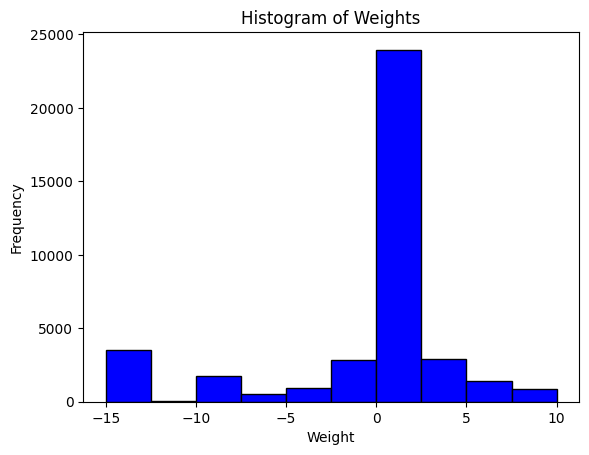

In [3]:
#histogram of weights 
plt.hist(feature_df_smogn["weight"], bins=10, color="blue", edgecolor="black")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.savefig("plots/histogram_of_weights_resampled.pdf")
plt.title("Histogram of Weights")
plt.show()

In [4]:
feature_df_smogn = feature_df_smogn.loc[feature_df_smogn["weight"] >= -10]
feature_df_smogn_08 = feature_df_smogn_08.loc[feature_df_smogn_08["weight"] >= -10]
feature_df_smogn_02 = feature_df_smogn_02.loc[feature_df_smogn_02["weight"] >= -10]

feature_df_smogn["weight"] = feature_df_smogn["weight"].astype(int)
feature_df_smogn_08["weight"] = feature_df_smogn_08["weight"].astype(int)
feature_df_smogn_02["weight"] = feature_df_smogn_02["weight"].astype(int)

#### Classification attempt

In [21]:
samplers = [RandomOverSampler(random_state=42), SMOTE(random_state=42), RandomUnderSampler(random_state=42)] #
sampler_names = ["RandomOverSampler","SMOTE","RandomUnderSampler"] #
dfs = []
for sampler_name, sampler in zip(sampler_names, samplers):
    print(f"Using {sampler_name}")
    X = feature_df[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy()
    y = feature_df["weight"].copy().to_numpy()

    # y = y + 10 #shift to 0-20
    # y[y > 10] = y[y > 10] - 1

    X = X[y > 0].copy()
    y = y[y > 0].copy()

    y = y - 1 
    
    # X, y = sampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)



    # Initialize models
    models = {
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        # 'Support Vector Machine': SVC(),
        'Naive Bayes': GaussianNB(),
        # 'Neural Network': MLPClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression()
        }

    # Training and evaluation loop
    accuracy_scores = []
    f1_scores = []

    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        #calculate f1 score
        f1 = f1_score(y_test, y_pred, average = "micro")
        
        # Print the accuracy of each model
        # print(f'{name} Accuracy: {accuracy:.4f}')
        # print(f'{name} F1 Score: {f1:.4f}')
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

        # print confusion matrix
        # print(f'{name} Confusion Matrix:')
        # print(confusion_matrix(y_test, y_pred))
    
    # Save the accuracy and f1 scores for each sampler
    df = pd.DataFrame({'Model': list(models.keys()), 'Accuracy': accuracy_scores, 'F1 Score': f1_scores})
    dfs.append(df)
    break

Using RandomOverSampler


/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
dfs

[                 Model  Accuracy  F1 Score
 0        Decision Tree  0.499338  0.499338
 1        Random Forest  0.596909  0.596909
 2              XGBoost  0.597351  0.597351
 3          Naive Bayes  0.588300  0.588300
 4  K-Nearest Neighbors  0.571744  0.571744
 5  Logistic Regression  0.601545  0.601545]

#### Classification Attempt with SMOGN

In [58]:
X = feature_df_smogn[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy()
y = feature_df_smogn["weight"].copy().to_numpy()


y = y + 10 #shift to 0-20
y[y > 10] = y[y > 10] - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    # 'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    # 'XGBoost': XGBClassifier(),
    # 'Support Vector Machine': SVC(),
    # 'Naive Bayes': GaussianNB(),
    # 'Neural Network': MLPClassifier(),
    # 'K-Nearest Neighbors': KNeighborsClassifier(),
    # 'Logistic Regression': LogisticRegression()
    }

# Training and evaluation loop
accuracy_scores = []
f1_scores = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    #calculate f1 score
    f1 = f1_score(y_test, y_pred, average = "micro")
    
    # Print the accuracy of each model
    # print(f'{name} Accuracy: {accuracy:.4f}')
    # print(f'{name} F1 Score: {f1:.4f}')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    # print confusion matrix
    print(f'{name} Confusion Matrix:')
    #revert back to original weights
    y_test[y_test >= 10] = y_test[y_test >= 10] + 1
    y_pred[y_pred >= 10] = y_pred[y_pred >= 10] + 1

    y_test = y_test - 10
    y_pred = y_pred - 10
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)

# Save the accuracy and f1 scores for each sampler
df = pd.DataFrame({'Model': list(models.keys()), 'Accuracy': accuracy_scores, 'F1 Score': f1_scores})
df

Random Forest Confusion Matrix:
[[ 243    0    0    2    0    0    0    0    0    6   61    2    4    0
     0    0    1    0    0    0]
 [   1    5    0    0    0    0    0    0    0    0    5    1    0    0
     0    0    0    0    0    0]
 [   0    0    3    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0   23    0   10    0    1    0    2   55    2    3    0
     0    0    0    1    0    0]
 [   0    0    0    0    2    0    0    0    0    0    3    1    1    0
     0    0    0    0    0    0]
 [   0    0    0    2    0   37    0    0    0    0    8    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    0   19    7    0    1   32    1    3    0
     1    0    0    0    0    0]
 [   0    0    0    0    0    0    1   37    6    1   27    4    0    0
     0    0    0    0    0    1]
 [   0    0    0    0    0    0    0    2   29    0    0    0    0    0
     0    0    0    0    0    0]
 [   4    0    2    1  

Model  Accuracy  F1 Score
0  Random Forest  0.697245  0.697245

In [68]:
index = np.arange(-10, 11)
index = np.delete(index, 10)
conf_matrix_df = pd.DataFrame(conf_matrix, index=index, columns=index)
#calculate mean correct per class as row
conf_matrix_df.loc["mean_correct"] = conf_matrix_df.apply(lambda x: x[x.name] / sum(x), axis=0)
conf_matrix_df.style.background_gradient(cmap='Blues')


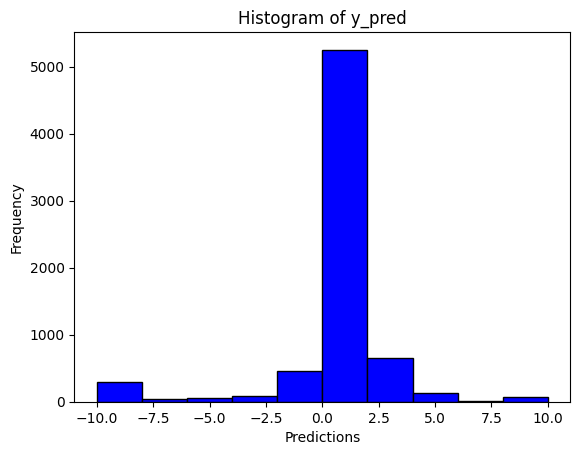

In [71]:
plt.hist(y_pred, bins=10, color="blue", edgecolor="black")
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.savefig("plots/histogram_of_weights_predicted_classifier.pdf")
plt.title('Histogram of y_pred')
plt.show()


#### Classification Attempt with split SMOGN

In [68]:
X_train, X_test = feature_df_smogn_08[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy(), feature_df_smogn_02[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy()
y_train, y_test = feature_df_smogn_08["weight"].copy().to_numpy(), feature_df_smogn_02["weight"].copy().to_numpy()

y_train = y_train + 10 #shift to 0-20
y_train[y_train > 10] = y_train[y_train > 10] - 1

y_test = y_test + 10 #shift to 0-20
y_test[y_test > 10] = y_test[y_test > 10] - 1

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    # 'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    # 'XGBoost': XGBClassifier(),
    # 'Support Vector Machine': SVC(),
    # 'Naive Bayes': GaussianNB(),
    # 'Neural Network': MLPClassifier(),
    # 'K-Nearest Neighbors': KNeighborsClassifier(),
    # 'Logistic Regression': LogisticRegression()
    }

# Training and evaluation loop
accuracy_scores = []
f1_scores = []
mae_scores = []
rmse_scores = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    #calculate f1 score
    f1 = f1_score(y_test, y_pred, average = "micro")

    #calculate MAE using scitkit learn
    mae = mean_absolute_error(y_test / 10, y_pred / 10)

    rmse = root_mean_squared_error(y_test / 10, y_pred / 10)
    
    # Print the accuracy of each model
    # print(f'{name} Accuracy: {accuracy:.4f}')
    # print(f'{name} F1 Score: {f1:.4f}')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"mae:{mae}")

    # print confusion matrix
    # print(f'{name} Confusion Matrix:')
    #revert back to original weights
    # y_test[y_test >= 10] = y_test[y_test >= 10] + 1
    # y_pred[y_pred >= 10] = y_pred[y_pred >= 10] + 1

    # y_test = y_test - 10
    # y_pred = y_pred - 10
    
    # conf_matrix = confusion_matrix(y_test, y_pred)
    # print(conf_matrix)

# Save the accuracy and f1 scores for each sampler
df = pd.DataFrame({'Model': list(models.keys()), 'Accuracy': accuracy_scores, 'F1 Score': f1_scores, 'MAE Scores':mae_scores, 'RMSE':rmse_scores})
df

mae:0.1382596114096734


Model  Accuracy  F1 Score  MAE Scores      RMSE
0  Random Forest  0.564903  0.564903     0.13826  0.295008

In [69]:
X_train

array([[0.0197638 , 0.14450423, 0.79291198],
       [0.00779139, 0.10760953, 0.79680697],
       [0.01086363, 0.11913912, 0.78559764],
       ...,
       [0.034317  , 0.03607383, 0.70559193],
       [0.0063241 , 0.12253514, 0.81697755],
       [0.02126557, 0.14072468, 0.80804282]])

In [101]:
index = np.arange(-10, 11)
index = np.delete(index, 10)
conf_matrix_df = pd.DataFrame(conf_matrix, index=index, columns=index)
#calculate mean correct per class as row
conf_matrix_df.loc["mean_correct"] = conf_matrix_df.apply(lambda x: x[x.name] / sum(x), axis=0)
conf_matrix_df.style.background_gradient(cmap='Blues')


/tmp/ipykernel_250605/780401896.py:5: RuntimeWarning: invalid value encountered in scalar divide
  conf_matrix_df.loc["mean_correct"] = conf_matrix_df.apply(lambda x: x[x.name] / sum(x), axis=0)


In [102]:
conf_matrix_df.to_numpy()

array([[1.60000000e+01, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.00000000e+00, 1.14000000e+02, 1.50000000e+01,
        3.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.0000

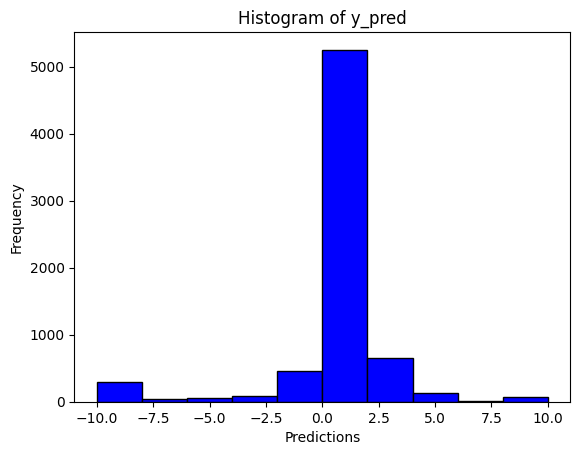

In [ ]:
plt.hist(y_pred, bins=10, color="blue", edgecolor="black")
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.savefig("plots/histogram_of_weights_predicted_classifier.pdf")
plt.title('Histogram of y_pred')
plt.show()


#### Regression

In [24]:
X_train, X_test = feature_df_smogn_08[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy(), feature_df_smogn_02[["edge_betweenness", "degree_centrality", "closeness_centrality"]].copy().to_numpy()
y_train, y_test = feature_df_smogn_08["weight"].copy().to_numpy(), feature_df_smogn_02["weight"].copy().to_numpy()

y_train = y_train + 10  # shift to 0-20
y_train[y_train > 10] = y_train[y_train > 10] - 1

y_test = y_test + 10  # shift to 0-20
y_test[y_test > 10] = y_test[y_test > 10] - 1

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    # 'Linear Regression': LinearRegression(),
    # 'Elastic Net': ElasticNet(),
    # 'GBDT': GradientBoostingRegressor(),
    # 'Support Vector Regression': SVR(),
    'Random Forest Regression': RandomForestRegressor(),
    # 'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    # 'XGBoost Regression': XGBRegressor()
}

mae_scores = []
rmse_scores = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate MAE and RMSE
    mae = mean_absolute_error(y_test / 10, y_pred / 10)
    rmse = root_mean_squared_error(y_test / 10, y_pred / 10)
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"{name} - MAE: {mae}, RMSE: {rmse}")
    print(f"Mean Prediction: {y_pred.mean()}")

# Save the MAE and RMSE scores for each model
df = pd.DataFrame({'Model': list(models.keys()), 'MAE': mae_scores, 'RMSE': rmse_scores})
df

Random Forest Regression - MAE: 0.1585836209954224, RMSE: 0.2735313327451628
Mean Prediction: 10.255369980507348


Model       MAE      RMSE
0  Random Forest Regression  0.158584  0.273531

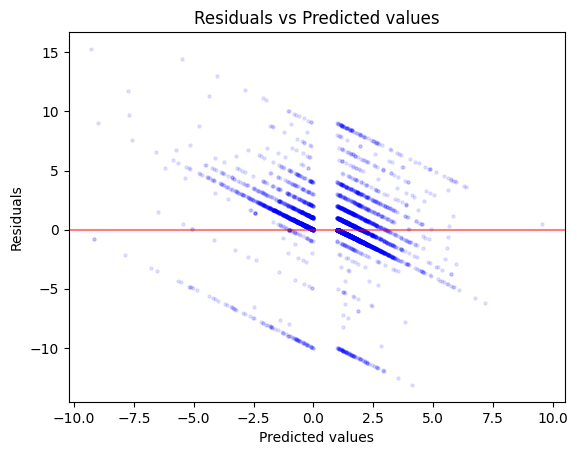

In [25]:
residuals = y_test - y_pred
y_pred[y_pred >= 10] = y_pred[y_pred >= 10] + 1
y_pred = y_pred - 10


plt.axhline(y=0, color='r', linestyle='-', alpha = 0.5)
plt.scatter(y_pred, residuals, color='blue', s = 5, alpha = 0.1)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
# plt.savefig("plots/G_regresions_residuals.pdf")
plt.title('Residuals vs Predicted values')
plt.show()

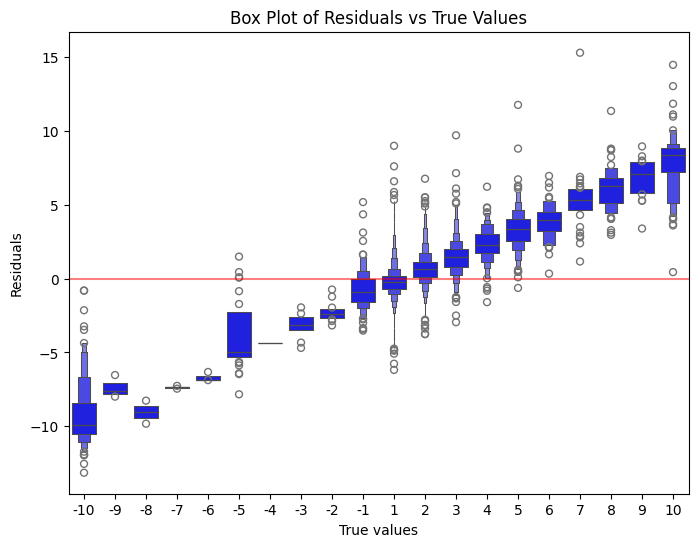

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

y_test[y_test >= 10] = y_test[y_test >= 10] + 1
y_test = y_test - 10


# Create violin plot
plt.figure(figsize=(8, 6))
sns.boxenplot(x=y_test, y=residuals, color='blue', alpha=1)
plt.axhline(y=0, color='red', linestyle='-', alpha=0.5)
plt.xlabel('True values')
plt.ylabel('Residuals')
plt.savefig("plots/G_regresions_residuals_box.pdf", bbox_inches='tight')
plt.title('Box Plot of Residuals vs True Values')
plt.show()

### H) Compare with Node2Vec

#### Generate Model

In [79]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs
# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

Computing transition probabilities:   0%|          | 2/3783 [00:00<04:25, 14.23it/s]/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/node2vec/node2vec.py:134: RuntimeWarning: divide by zero encountered in divide
  source] = unnormalized_weights / unnormalized_weights.sum()
Computing transition probabilities:  20%|█▉        | 739/3783 [00:09<00:23, 129.30it/s]/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/node2vec/node2vec.py:143: RuntimeWarning: divide by zero encountered in divide
  d_graph[source][self.FIRST_TRAVEL_KEY] = first_travel_weights / first_travel_weights.sum()
Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/random.py:488: RuntimeWarning: invalid value encountered in scalar add
  cum_weights = list(_accumulate(weights))
Generating walks (CPU: 2):   0%|          | 0/50 [00:00<?, ?it/s]/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/random.py:488: RuntimeWarning: inval

In [80]:
model.save("model/node2vec_model_64")

#### Load Model

In [12]:
# Load the Node2Vec model
dimension = 64
model = Word2Vec.load(f"model/node2vec_model_{dimension}")

In [13]:
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [14]:
feature_df = pd.read_csv("data/feature_df.csv")
feature_df["embeding"] = feature_df.apply(lambda x: edges_embs[str(x["source"]), str(x["target"])], axis=1)
feature_df

source  target  weight          edge  edge_betweenness  \
0        7188       1      10     (7188, 1)          0.000262   
1         430       1      10      (430, 1)          0.000416   
2        3134       1      10     (3134, 1)          0.000111   
3        3026       1      10     (3026, 1)          0.000262   
4        3010       1      10     (3010, 1)          0.000262   
...       ...     ...     ...           ...               ...   
24181    7604    7601      10  (7604, 7601)          0.000019   
24182    7601    7604      10  (7601, 7604)          0.000007   
24183    7604    7602      10  (7604, 7602)          0.000017   
24184    7602    7604      10  (7602, 7604)          0.000005   
24185    7604    7603     -10  (7604, 7603)          0.000160   

       edge_betweenness_weighted  degree_centrality_source  \
0                       0.000248                  0.000264   
1                       0.000000                  0.003966   
2                       0.000000                  0.001851   
3                       0.000247                  0.000529   
4                       0.000247                  0.000529   
...                          ...                       ...   
24181                   0.000000                  0.024855   
24182                   0.000000                  0.007139   
24183                   0.000000                  0.024855   
24184                   0.000000                  0.007932   
24185                   0.034034                  0.024855   

       degree_centrality_target  degree_centrality  \
0                      0.234796           0.117530   
1                      0.234796           0.119381   
2                      0.234796           0.118324   
3                      0.234796           0.117663   
4                      0.234796           0.117663   
...                         ...                ...   
24181                  0.007139           0.015997   
24182                  0.024855           0.015997   
24183                  0.007932           0.016393   
24184                  0.024855           0.016393   
24185                  0.042041           0.033448   

       closeness_centrality_source  closeness_centrality_target  \
0                         0.000000                     0.358772   
1                         0.244136                     0.358772   
2                         0.271134                     0.358772   
3                         0.253285                     0.358772   
4                         0.253285                     0.358772   
...                            ...                          ...   
24181                     0.318664                     0.279984   
24182                     0.279984                     0.318664   
24183                     0.318664                     0.283694   
24184                     0.283694                     0.318664   
24185                     0.318664                     0.327176   

       closeness_centrality  sign  \
0                  0.179386     1   
1                  0.301454     1   
2                  0.314953     1   
3                  0.306028     1   
4                  0.306028     1   
...                     ...   ...   
24181              0.299324     1   
24182              0.299324     1   
24183              0.301179     1   
24184              0.301179     1   
24185              0.322920    -1   

                                                embeding  
0      [-0.033544406, 0.030328205, 0.09554062, 0.0090...  
1      [0.009597834, 0.08104516, -0.1716074, -0.00999...  
2      [-0.024927538, 0.018194178, 0.035684325, 0.025...  
3      [0.020015689, 0.07892415, 0.06170452, 0.018600...  
4      [0.028264796, 0.032692622, 0.07490814, 0.00752...  
...                                                  ...  
24181  [0.358853, 0.09406236, 0.061616696, 0.06216935...  
24182  [0.358853, 0.09406236, 0.061616696, 0.06216935...  
24183  [0.42756832, 0.21404618, 0.025253, 0.0933474

#### Sign Prediction

In [15]:
X = feature_df["embeding"].copy().to_numpy()
X = np.vstack(np.ravel(X))
y = feature_df["sign"].copy().to_numpy()

#change -1 to 0
y[y == -1] = 0


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Support Vector Machine': SVC(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression()
    }

# Training and evaluation loop
accuracy_scores = []
f1_scores = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    #calculate f1 score
    f1 = f1_score(y_test, y_pred)
    
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    # print confusion matrix
    print(f'{name} Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

# Save the accuracy and f1 scores for each sampler
df = pd.DataFrame({'Model': list(models.keys()), 'Accuracy': accuracy_scores, 'F1 Score': f1_scores})
df
    

#dimension 64

Decision Tree Confusion Matrix:
[[ 150  163]
 [ 304 4221]]
Random Forest Confusion Matrix:
[[ 150  163]
 [ 111 4414]]
XGBoost Confusion Matrix:
[[ 176  137]
 [ 186 4339]]
Support Vector Machine Confusion Matrix:
[[ 243   70]
 [1006 3519]]
Naive Bayes Confusion Matrix:
[[ 244   69]
 [2563 1962]]


/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Confusion Matrix:
[[ 207  106]
 [ 709 3816]]
K-Nearest Neighbors Confusion Matrix:
[[ 229   84]
 [ 748 3777]]
Logistic Regression Confusion Matrix:
[[ 226   87]
 [1479 3046]]


Model  Accuracy  F1 Score
0           Decision Tree  0.903473  0.947581
1           Random Forest  0.943365  0.969897
2                 XGBoost  0.933237  0.964115
3  Support Vector Machine  0.777594  0.867390
4             Naive Bayes  0.455974  0.598536
5          Neural Network  0.831542  0.903516
6     K-Nearest Neighbors  0.828028  0.900787
7     Logistic Regression  0.676313  0.795508

In [72]:
X = feature_df["embeding"].to_numpy()
X = np.vstack(np.ravel(X))
y = feature_df["sign"].copy().to_numpy()

#change -1 to 0
y[y == -1] = 0


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Support Vector Machine': SVC(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression()
    }

# Training and evaluation loop
accuracy_scores = []
f1_scores = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    #calculate f1 score
    f1 = f1_score(y_test, y_pred)
    
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    # print confusion matrix
    print(f'{name} Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

# Save the accuracy and f1 scores for each sampler
df = pd.DataFrame({'Model': list(models.keys()), 'Accuracy': accuracy_scores, 'F1 Score': f1_scores})
df
    

#dimension 3

Decision Tree Confusion Matrix:
[[ 150  163]
 [ 368 4157]]
Random Forest Confusion Matrix:
[[ 147  166]
 [ 281 4244]]
XGBoost Confusion Matrix:
[[ 164  149]
 [ 840 3685]]
Support Vector Machine Confusion Matrix:
[[ 269   44]
 [3154 1371]]
Naive Bayes Confusion Matrix:
[[ 298   15]
 [4053  472]]


/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Confusion Matrix:
[[ 215   98]
 [2538 1987]]
K-Nearest Neighbors Confusion Matrix:
[[ 164  149]
 [ 850 3675]]
Logistic Regression Confusion Matrix:
[[ 260   53]
 [3260 1265]]


Model  Accuracy  F1 Score
0           Decision Tree  0.890244  0.939966
1           Random Forest  0.907606  0.949972
2                 XGBoost  0.795577  0.881684
3  Support Vector Machine  0.338983  0.461616
4             Naive Bayes  0.159157  0.188348
5          Neural Network  0.455147  0.601210
6     K-Nearest Neighbors  0.793510  0.880345
7     Logistic Regression  0.315213  0.432997

In [73]:
X = feature_df["embeding"].to_numpy()
X = np.vstack(np.ravel(X))
y = feature_df["sign"].copy().to_numpy()

#change -1 to 0
y[y == -1] = 0


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    # 'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    # 'XGBoost': XGBClassifier(),
    # 'Support Vector Machine': SVC(),
    # 'Naive Bayes': GaussianNB(),
    # 'Neural Network': MLPClassifier(),
    # 'K-Nearest Neighbors': KNeighborsClassifier(),
    # 'Logistic Regression': LogisticRegression()
    }

# Training and evaluation loop
accuracy_scores = []
f1_scores = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    #calculate f1 score
    f1 = f1_score(y_test, y_pred)
    
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    # print confusion matrix
    print(f'{name} Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

# Save the accuracy and f1 scores for each sampler
df = pd.DataFrame({'Model': list(models.keys()), 'Accuracy': accuracy_scores, 'F1 Score': f1_scores})
df

Random Forest Confusion Matrix:
[[ 145  168]
 [ 284 4241]]


Model  Accuracy  F1 Score
0  Random Forest  0.906573  0.949407

#### Regression

##### Create Dataset

In [16]:
feature_df_reduced = feature_df[["embeding", "weight"]].copy()
#extract embedding vector into columns

feature_df_reduced[[i for i in range(0, dimension) ]] = feature_df_reduced['embeding'].apply(lambda x: pd.Series(x))
feature_df_reduced.drop(columns = ["embeding"], inplace=True)
feature_df_reduced = feature_df_reduced.reset_index(drop=True)

In [17]:
X = feature_df_reduced.drop(columns=['weight'])
y = feature_df_reduced['weight']

# Splitting the data into train and test sets (adjust test_size and random_state as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating train and test DataFrames
feature_df_smogn_08 = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
feature_df_smogn_02 = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)



#ram into bug that was fixed with https://github.com/nickkunz/smogn/issues/11 -> need to modify local files
feature_df_smogn_08 = smogn.smoter(
    data = feature_df_smogn_08,  ## pandas dataframe
    y = 'weight'  ## string ('header name')
)

/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/smogn/phi.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  delta.append((y_rel[i + 1] - y_rel[i]) / h[i])
r_index: 100%|##########| 333/333 [00:03<00:00, 83.62it/s]


In [18]:
feature_df_smogn_08.to_csv(f"data/feature_df_smogn_node2vec_{dimension}_08.csv", index=False)
feature_df_smogn_02.to_csv(f"data/feature_df_smogn_node2vec_{dimension}_02.csv", index=False)

##### Use Dataset

In [19]:
feature_df_smogn_08 = pd.read_csv(f"data/feature_df_smogn_node2vec_{dimension}_08.csv")
feature_df_smogn_02 = pd.read_csv(f"data/feature_df_smogn_node2vec_{dimension}_02.csv")

In [20]:
X_train, X_test = feature_df_smogn_08.drop(columns=['weight']).copy().to_numpy(), feature_df_smogn_02.drop(columns=['weight']).copy().to_numpy()
y_train, y_test = feature_df_smogn_08["weight"].copy().to_numpy(), feature_df_smogn_02["weight"].copy().to_numpy()

y_train = y_train + 10  # shift to 0-20
y_train[y_train > 10] = y_train[y_train > 10] - 1

y_test = y_test + 10  # shift to 0-20
y_test[y_test > 10] = y_test[y_test > 10] - 1

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Elastic Net': ElasticNet(),
    'GBDT': GradientBoostingRegressor(),
    'Support Vector Regression': SVR(),
    'Random Forest Regression': RandomForestRegressor(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'XGBoost Regression': XGBRegressor()
}

mae_scores = []
rmse_scores = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate MAE and RMSE
    mae = mean_absolute_error(y_test / 10, y_pred / 10)
    rmse = root_mean_squared_error(y_test / 10, y_pred / 10)
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"{name} - MAE: {mae}, RMSE: {rmse}")
    print(f"Mean Prediction: {y_pred.mean()}")

# Save the MAE and RMSE scores for each model
df = pd.DataFrame({'Model': list(models.keys()), 'MAE': mae_scores, 'RMSE': rmse_scores})
df

#64 dimensions

Linear Regression - MAE: 0.2518349092783005, RMSE: 0.3384945472516863
Mean Prediction: 8.871647034491875
Elastic Net - MAE: 0.2521364777872135, RMSE: 0.3306899617452098
Mean Prediction: 8.63894529864939


GBDT - MAE: 0.2095186735927469, RMSE: 0.3017670862776776
Mean Prediction: 9.186311908623905
Support Vector Regression - MAE: 0.13895924925073264, RMSE: 0.26587890153088045
Mean Prediction: 9.984263971168422
Random Forest Regression - MAE: 0.1310451667424487, RMSE: 0.24058739986901354
Mean Prediction: 10.031356025881244
K-Nearest Neighbors Regressor - MAE: 0.21135179826374534, RMSE: 0.36012399683486906
Mean Prediction: 9.872633319553534
XGBoost Regression - MAE: 0.17177728797969768, RMSE: 0.2735234463851878
Mean Prediction: 10.056720733642578


Model       MAE      RMSE
0              Linear Regression  0.251835  0.338495
1                    Elastic Net  0.252136  0.330690
2                           GBDT  0.209519  0.301767
3      Support Vector Regression  0.138959  0.265879
4       Random Forest Regression  0.131045  0.240587
5  K-Nearest Neighbors Regressor  0.211352  0.360124
6             XGBoost Regression  0.171777  0.273523

In [11]:
#3 dimensional 
df

Model       MAE      RMSE
0              Linear Regression  0.259192  0.333222
1                    Elastic Net  0.258008  0.334381
2                           GBDT  0.244097  0.327967
3      Support Vector Regression  0.135115  0.275378
4       Random Forest Regression  0.155340  0.276655
5  K-Nearest Neighbors Regressor  0.217015  0.358402
6             XGBoost Regression  0.213050  0.318381